# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Modelado y Generación Musical: Una Aproximación Mediante Redes Neuronales y Entradas MIDI</p>


<p style="font-family:Segoe UI;font-size:120%;color:#FFFFF;">Welcome to this Jupyter Notebook, the digital canvas where my two greatest passions converge: music and machine learning. At the heart of this exploration lies a fascination with the intricate dance between technology and melody, an adventure into how ML can transform MIDI notes into captivating symphonies. As we embark on this journey together, we delve into the algorithms and creativity that fuel the future of music generation. Music, my utmost passion, serves as both the inspiration and the destination for this academic endeavor. Join me as we uncover the melodies that lie waiting in the realm of bits and bytes, crafting harmonies guided by the science of artificial intelligence.</p> 

<div class="list-group" id="list-tab" role="tablist">
 <p style="font-family:newtimeroman;color:#97BACB#97BACB;font-size:120%;text-align:center;border-radius:40px 40px;">TABLE OF CONTENTS</p>

    
* [1. Install Dependencies](#1)
    
* [2. Importing Libraries](#2)
    
* [3. Data Processing](#3)  
    
* [4. Data Exploration](#4)  
    
* [5. MODEL BUILDING](#5) 
      
* [6. EVALUATING MODELS](#6)
    
* [7. CONCLUSION](#7)
    
* [8. END](#8)


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Install Dependencies</p>

In [5]:
%pip install pretty_midi
%pip install pypianoroll
%pip install datasets
%pip install torch
%pip install matplotlib
%pip install seaborn    
%pip install music21
%pip install sklearn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklea

# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Importing Libraries</p>

In [6]:
import pretty_midi
import pandas as pd
import numpy as np
import os
import pypianoroll
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import seaborn as sns
import torch
import music21
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score



# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Data Processing</p>


<p style="font-family:Segoe UI;font-size:120%;color:#FFFFF;">For this project we will be using MIDI files. We have a few MIDI files focusing mainly on Classical Music, like Bach, Mozzart, Chopin and Schubert. On the other hand, we have files of jazz piano music, extracts of songs like Little Girl Blue, Come Rain or Come Sunshine and New Orleans, among others </p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Here's an expanded explanation of the features we are extractinh from the MIDI files and why they are important for your project:</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Note Attributes (Pitch, Start Time, End Time, Velocity): </p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Pitch indicates the note's frequency, essential for determining the melody and harmony.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Start Time and End Time provide temporal information about when a note is played and for how long, crucial for the rhythm and phrasing.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Velocity reflects the dynamics of each note, adding expressiveness to the music.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Number of Instruments: Understanding the number of instruments in a piece can help the model learn textural and ensemble complexity, which is key to generating more varied and interesting compositions.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Duration of the Piece: The overall length of a piece can influence the model's ability to generate music with coherent structures over different time scales.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Tempo Changes: The number of tempo changes can indicate sections within a piece and help the model learn about pacing and expression.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Key Signatures: Key signatures provide context on the tonality, helping in generating musically coherent pieces that adhere to a tonal center or modulate interestingly.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Time Signatures: Time signatures are fundamental for understanding the metric structure, enabling the model to generate music with consistent or varied rhythmic patterns.</p>

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Average, Minimum, and Maximum Pitch: These statistics give insights into the melodic range of a piece, informing the model about the pitch content it might generate to stay within a realistic and expressive range.</p>

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Average Velocity: Indicates the overall dynamics of a piece, guiding the model to generate music with appropriate loudness levels across different sections.</p>

In [7]:
#FUNCTION TO PROCESS ALL MIDI FILES 
def process_midi_files(folder_path):
    file_data = []
    instrument_names = [] 
    for filename in os.listdir(folder_path):
        if filename.endswith('.mid') or filename.endswith('.midi'):
            try:
                # Load the MIDI file
                midi_path = os.path.join(folder_path, filename)
                midi_data = pretty_midi.PrettyMIDI(midi_path)
                music21_stream = music21.converter.parse(midi_path)  # Parse the MIDI file with music21
                print(f"Processing {filename}...")
                
                all_notes = []
                pitches = []
                velocities = []
                start_times = []
                durations = []
                pitch_classes = [0] * 12  # 12 pitch classes for chromatic scale
                file_instrument_names = []
                
                for instrument in midi_data.instruments:
                    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
                    file_instrument_names.append(instrument_name)
                    instrument_names.append(instrument_name)
                    for note in instrument.notes:
                        note_repr = f"({note.pitch},{note.start:.2f},{note.end:.2f},{note.velocity})"
                        all_notes.append(note_repr)
                        pitches.append(note.pitch)
                        velocities.append(note.velocity)
                        start_times.append(note.start)
                        durations.append(note.end - note.start)
                        pitch_classes[note.pitch % 12] += 1  # Increment pitch class count
                
                # Extracting key using music21
                key = music21_stream.analyze('key')
                main_key = f"{key.tonic.name} {key.mode}"

                instruments_str = ', '.join(set(file_instrument_names))
                
                # Extract chords using music21
                chords = set()
                for element in music21_stream.recurse().getElementsByClass('Chord'):
                    chords.add('.'.join(str(p.midi) for p in element.pitches))
                chords_str = ', '.join(chords)
                
                notes_str = ' '.join(all_notes)
                
                avg_pitch = np.mean(pitches) if pitches else 0
                min_pitch = np.min(pitches) if pitches else None
                max_pitch = np.max(pitches) if pitches else None
                avg_velocity = np.mean(velocities) if velocities else 0
                avg_duration = np.mean(durations) if durations else 0
                
                # Calculating polyphony (simultaneous note occurrences)
                polyphony = len([d for d in durations if d > 0]) / midi_data.get_end_time() if durations else 0
                
                # Time between consecutive notes
                intervals = np.diff(sorted(start_times))
                avg_interval = np.mean(intervals) if intervals.size > 0 else 0
                
                tempo_changes = len(midi_data.get_tempo_changes()[0])
                key_signatures = len(midi_data.key_signature_changes)
                time_signatures = len(midi_data.time_signature_changes)
                
                duration = midi_data.get_end_time()
                num_instruments = len(midi_data.instruments)
                
                file_data.append({
                    'filename': filename,
                    'num_instruments': num_instruments,
                    'instruments': instruments_str,
                    'duration': duration,
                    'tempo_changes': tempo_changes,
                    'key_signatures': key_signatures,
                    'time_signatures': time_signatures,
                    'avg_pitch': avg_pitch,
                    'min_pitch': min_pitch,
                    'max_pitch': max_pitch,
                    'avg_velocity': avg_velocity,
                    'avg_duration': avg_duration,
                    'polyphony': polyphony,
                    'avg_interval': avg_interval,
                    'pitch_classes': pitch_classes,  # Pitch class distribution
                    'main_key': main_key,  # Main key of the piece
                    'chords': chords_str,  # Chord progressions
                    'notes': notes_str,  # Note sequences
                })
                print(f"Processed {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    return pd.DataFrame(file_data)



In [8]:
#LOCAL FOLDER PATH
folder_path = '/Users/santiago.perez.gutierrez/Documents/ITAM/Tesina/Dataset Final'

#HUGGING FACE DATASET
#dataset = load_dataset('SantiagoPG/classical_music') 

midi_data = process_midi_files(folder_path)

Processing muss_2.mid...
Processed muss_2.mid
Processing mendel_op19_1.mid...
Processed mendel_op19_1.mid
Processing muss_3.mid...
Processed muss_3.mid
Processing muss_1.mid...
Processed muss_1.mid
Processing mendel_op19_3.mid...
Processed mendel_op19_3.mid
Processing schum_abegg.mid...
Processed schum_abegg.mid
Processing gra_esp_4.mid...
Processed gra_esp_4.mid
Processing islamei.mid...
Processed islamei.mid
Processing mendel_op19_2.mid...
Processed mendel_op19_2.mid
Processing Irememberyousolo.mid...
Processed Irememberyousolo.mid
Processing bach_847.mid...
Processed bach_847.mid
Processing schub_d960_1.mid...
Processed schub_d960_1.mid
Processing MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_08_Track08_wav.midi...
Processed MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_08_Track08_wav.midi
Processing DaysofWine.mid...
Processed DaysofWine.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'Copyright 2004 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


Processing bach_846.mid...
Processed bach_846.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Pr\xe4ludium und Fuge in D-Dur, BWV 850'>; getting generic Instrument
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'Copyright 1997 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


Processing bach_850.mid...
Processed bach_850.mid
Processing gra_esp_2.mid...
Processed gra_esp_2.mid
Processing gra_esp_3.mid...
Processed gra_esp_3.mid
Processing Come Rain or Come Shine V1.mid...
Processed Come Rain or Come Shine V1.mid
Processing MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--4.midi...
Processed MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--4.midi


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing chpn_op25_e4.mid...
Processed chpn_op25_e4.mid
Processing MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2.midi...
Processed MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2.midi


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1996 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing schuim-4.mid...
Processed schuim-4.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing chpn_op25_e1.mid...
Processed chpn_op25_e1.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke Op. 43 No. 1 - Schmetterling'>; getting generic Instrument
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2007 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing grieg_butterfly.mid...
Processed grieg_butterfly.mid
Processing Chopin, Frédéric, Études, Op.10, g0hoN6_HDVU.mid...
Processed Chopin, Frédéric, Études, Op.10, g0hoN6_HDVU.mid
Processing schuim-3.mid...
Processed schuim-3.mid
Processing chpn_op25_e2.mid...
Processed chpn_op25_e2.mid
Processing chpn_op25_e3.mid...
Processed chpn_op25_e3.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke, Albumblatt, Opus 42 Nr. 2'>; getting generic Instrument
  warnings.warn(


Processing grieg_album.mid...
Processed grieg_album.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Processing mz_332_3.mid...
Processed mz_332_3.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2012 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing grieg_berceuse.mid...
Processed grieg_berceuse.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing scn15_4.mid...
Processed scn15_4.mid
Processing MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--3.midi...
Processed MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--3.midi


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Processing mz_330_2.mid...
Processed mz_330_2.mid
Processing DeepPurple.mid...
Processed DeepPurple.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke, B\xe4chlein, Opus 62 Nr. 4'>; getting generic Instrument
  warnings.warn(


Processing grieg_brooklet.mid...
Processed grieg_brooklet.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing mz_545_3.mid...
Processed mz_545_3.mid
Processing schub_d760_4.mid...
Processed schub_d760_4.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Gl\xfcckes genug'>; getting generic Instrument
  warnings.warn(


Processing scn15_5.mid...
Processed scn15_5.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2009 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing schubert_D850_1.mid...
Processed schubert_D850_1.mid
Processing merryxmas.mid...
Processed merryxmas.mid
Processing MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.midi...
Processed MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.midi
Processing Autumn In NY.mid...
Processed Autumn In NY.mid
Processing schub_d760_1.mid...
Processed schub_d760_1.mid
Processing scn15_2.mid...
Processed scn15_2.mid
Processing schubert_D850_2.mid...
Processed schubert_D850_2.mid
Processing schub_d760_3.mid...
Processed schub_d760_3.mid
Processing beethoven_rondo_a_capriccio_op_129_smythe.mid...
Processed beethoven_rondo_a_capriccio_op_129_smythe.mid
Processing schubert_D850_3.mid...
Processed schubert_D850_3.mid
Processing schub_d760_2.mid...
Processed schub_d760_2.mid
Processing scn15_3.mid...
Processed scn15_3.mid
Processing schu_143_2.mid...
Processed schu_143_2.mid
Processing bor_ps1.mid...
Processed bor_ps1.mid
Processing alb_esp3.mid...
Processed alb_esp3.mid
Proces

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1999 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Processing schu_143_3.mid...
Processed schu_143_3.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Baba-Yaga  - Das gro\xdfe Tor von Kiew'>; getting generic Instrument
  warnings.warn(


Processing muss_8.mid...
Processed muss_8.mid
Processing schu_143_1.mid...
Processed schu_143_1.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Processing mz_331_1.mid...
Processed mz_331_1.mid
Processing bor_ps2.mid...
Processed bor_ps2.mid
Processing br_im5.mid...
Processed br_im5.mid
Processing debussy_cc_4.mid...
Processed debussy_cc_4.mid
Processing alb_esp1.mid...
Processed alb_esp1.mid
Processing bor_ps3.mid...
Processed bor_ps3.mid
Processing beethoven_sonata_no_3_cut_mov_1.mid...
Processed beethoven_sonata_no_3_cut_mov_1.mid
Processing Dreamsville.mid...
Processed Dreamsville.mid
Processing bor_ps7.mid...
Processed bor_ps7.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing chpn-p17.mid...
Processed chpn-p17.mid
Processing bor_ps6.mid...
Processed bor_ps6.mid
Processing bor_ps4.mid...
Processed bor_ps4.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke Op. 12 Nr. 4 Elfentanz'>; getting generic Instrument
  warnings.warn(


Processing grieg_elfentanz.mid...
Processed grieg_elfentanz.mid
Processing Little Girl Blue.mid...
Processed Little Girl Blue.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Processing br_im2.mid...
Processed br_im2.mid
Processing bor_ps5.mid...
Processed bor_ps5.mid
Processing MIDI-Unprocessed_Schubert4-6_MID--AUDIO_08_R2_2018_wav.midi...
Processed MIDI-Unprocessed_Schubert4-6_MID--AUDIO_08_R2_2018_wav.midi
Processing MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--3.midi...
Processed MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--3.midi


In [9]:
midi_data.head()

#Save midi_data limit to 10 into a csv file
#midi_data.head(10).to_csv('midi_data.csv', index=False)

,filename,num_instruments,instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,avg_velocity,avg_duration,polyphony,avg_interval,pitch_classes,main_key,chords,notes
0,muss_2.mid,3,Acoustic Grand Piano,294.345044,472,2,13,58.512764,32,94,39.164843,0.823738,4.657799,0.210788,"[34, 119, 37, 191, 120, 40, 56, 46, 515, 33, 1...",G# minor,"91.79, 69.81, 68.65, 56.61.65, 79.67.75.70, 54...","(61,7.15,7.80,34) (65,7.15,7.80,34) (68,7.15,7..."
1,mendel_op19_1.mid,3,Acoustic Grand Piano,163.375953,541,1,1,59.155311,30,84,38.610256,0.339504,8.354963,0.116222,"[37, 100, 33, 114, 223, 7, 207, 48, 139, 108, ...",E major,"62.60.57.54, 66.68, 69.68, 56.64, 40.47","(69,4.42,5.05,51) (68,5.05,5.67,57) (66,5.67,6..."
2,muss_3.mid,2,Acoustic Grand Piano,89.440365,310,2,8,67.607626,27,90,47.820418,0.355700,9.089856,0.106152,"[15, 86, 32, 140, 32, 65, 151, 28, 88, 25, 30,...",B major,"88.76, 49.65, 49.57, 64.68.71, 78.82.70.73, 66...","(68,0.00,0.64,77) (56,0.00,0.64,65) (54,0.64,1..."
3,muss_1.mid,2,Acoustic Grand Piano,210.571309,1036,2,21,56.749396,27,94,61.642512,0.438788,7.864319,0.126381,"[122, 47, 130, 245, 58, 232, 106, 127, 77, 144...",E- major,"65.74, 69.81, 77.65, 60.57.65, 75.67.70.79, 54...","(67,0.00,0.63,90) (65,0.60,1.22,85) (70,1.20,1..."
4,mendel_op19_3.mid,2,Acoustic Grand Piano,137.633716,430,1,1,65.702386,28,97,57.596902,0.186539,17.357665,0.057595,"[11, 436, 127, 73, 516, 5, 249, 1, 214, 448, 3...",A major,"76.73, 75.78, 69.81, 69.71, 88.76, 64.52, 52.5...","(64,0.57,1.32,70) (61,1.32,1.41,69) (64,1.41,1..."


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Data Exploration</p>


In [13]:
midi_data.describe()

,num_instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,avg_velocity,avg_duration,polyphony,avg_interval
count,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,1.950000,355.203871,721.53750,1.637500,2.150000,63.909082,30.650000,93.537500,50.985799,0.364629,9.440598,0.125131
std,0.898663,477.106413,825.88806,2.153853,3.349287,3.232086,5.502819,7.896392,9.490161,0.210687,3.966274,0.061301
min,1.000000,31.358879,1.00000,0.000000,1.000000,55.765983,14.000000,79.000000,31.555907,0.084478,2.522720,0.052422
25%,2.000000,140.463117,177.25000,1.000000,1.000000,61.891308,27.000000,87.500000,44.777525,0.204318,6.639255,0.080660
50%,2.000000,210.663588,439.50000,1.000000,1.000000,64.027601,29.500000,93.000000,49.669684,0.317888,8.948306,0.108682
75%,2.000000,385.980859,994.00000,1.250000,1.000000,65.729141,35.000000,101.000000,56.755332,0.469795,12.188866,0.147546
max,6.000000,3752.264323,3567.00000,16.000000,21.000000,73.266047,45.000000,108.000000,70.726400,1.150738,18.155460,0.392356


In [14]:
midi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         80 non-null     object 
 1   num_instruments  80 non-null     int64  
 2   instruments      80 non-null     object 
 3   duration         80 non-null     float64
 4   tempo_changes    80 non-null     int64  
 5   key_signatures   80 non-null     int64  
 6   time_signatures  80 non-null     int64  
 7   avg_pitch        80 non-null     float64
 8   min_pitch        80 non-null     int64  
 9   max_pitch        80 non-null     int64  
 10  avg_velocity     80 non-null     float64
 11  avg_duration     80 non-null     float64
 12  polyphony        80 non-null     float64
 13  avg_interval     80 non-null     float64
 14  pitch_classes    80 non-null     object 
 15  main_key         80 non-null     object 
 16  chords           80 non-null     object 
 17  notes            8

In [15]:
#SUM of midi_date[duration]to get total duration of all midi files
midi_data['duration'].sum()

total_duration = midi_data['duration'].sum()/60
print(f"Total duration of all MIDI files: {total_duration:.2f} minutes")

Total duration of all MIDI files: 473.61 minutes


In [16]:
def count_notes(note_str):
    return len(note_str.split(' ')) if pd.notna(note_str) else 0


In [17]:
tota_notes= midi_data['notes'].apply(count_notes).sum()
#change format to be readable
tota_notes = "{:,}".format(tota_notes)
print(f"Total notes: {tota_notes}")

Total notes: 271,565


In [18]:
def count_chords(chords_str):
    return len(chords_str.split(', ')) if pd.notna(chords_str) else 0

In [19]:
tota_chords = midi_data['chords'].apply(count_chords).sum()
#change format to be readable
tota_chords = "{:,}".format(tota_chords)
print(f"Total chords: {tota_chords}")

Total chords: 31,254


### Function to Plot a Piano Roll of one of the files.

In [20]:

def plot_piano_roll(midi_path, start_time=0, end_time=None, fs=100):
    
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    # Get the piano roll
    piano_roll = midi_data.get_piano_roll(fs=fs)
    
    # If end_time is not specified, use the last time of the piano roll
    if end_time is None:
        end_time = piano_roll.shape[1] / fs
    
    # Convert time to frames
    start_frame = int(start_time * fs)
    end_frame = int(end_time * fs)
    
    # Plot the piano roll
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.imshow(piano_roll[:, start_frame:end_frame], 
              aspect='auto', 
              origin='lower', 
              cmap='gray_r', 
              interpolation='nearest')
    
    # Set the y-axis labels to note names
    note_names = [pretty_midi.note_number_to_name(note_number) for note_number in np.arange(128)]
    ax.set_yticks(np.arange(0, 128, 12))
    ax.set_yticklabels(note_names[::12])
    
    # Set the x-axis labels to time in seconds
    ax.set_xticks(np.linspace(0, end_frame - start_frame, 5))
    ax.set_xticklabels(np.linspace(start_time, end_time, 5))
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Note')
    ax.set_title('Piano Roll')
    
    plt.show()


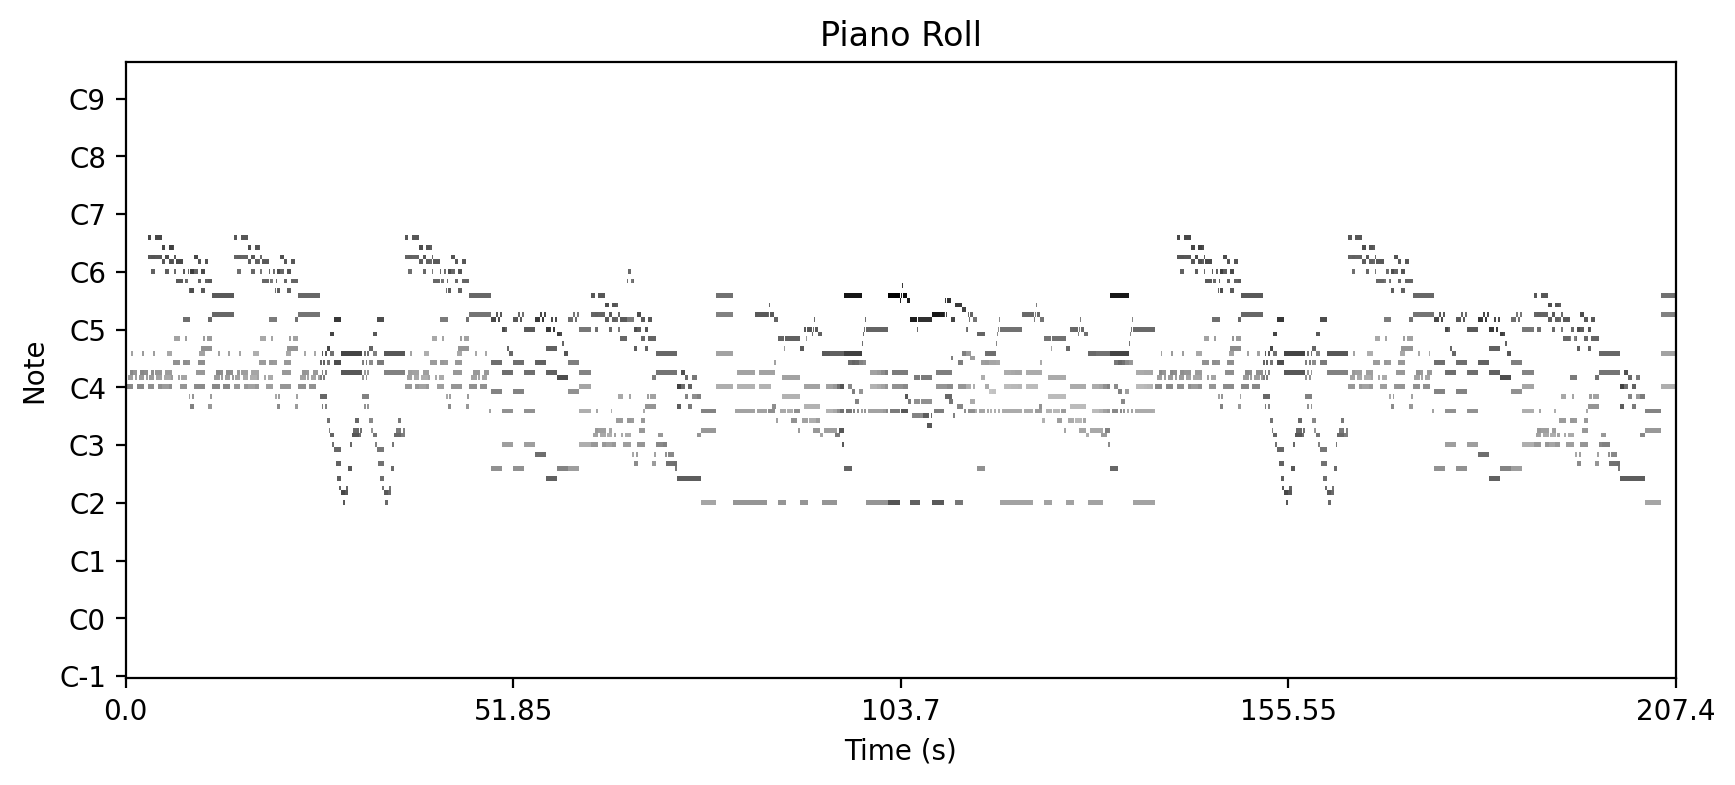

In [21]:
plot_piano_roll('/Users/santiago.perez.gutierrez/Documents/ITAM/Tesina/Dataset Final/gra_esp_2.mid')

### Number of Instruments

In [22]:
def plot_instrument_distribution(midi_data):
    # Create the countplot
    ax = sns.countplot(x='num_instruments', data=midi_data)
    plt.title('Distribution of Number of Instruments')

    # Adding values on top of the bars
    for p in ax.patches:
        # Get the height of the bar (which represents the data value)
        height = p.get_height()
        # Place a text label above the bar
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1, '%d' % int(height), ha='center')

    plt.show()

In [23]:
midi_data['instruments'].unique()

array(['Acoustic Grand Piano', 'Bright Acoustic Piano',
       'Acoustic Bass, Violin, Acoustic Grand Piano'], dtype=object)

In [24]:
#Delete rows with other instruments that are not Acoustic Grand Piano
midi_data = midi_data[midi_data['instruments'] == 'Acoustic Grand Piano']

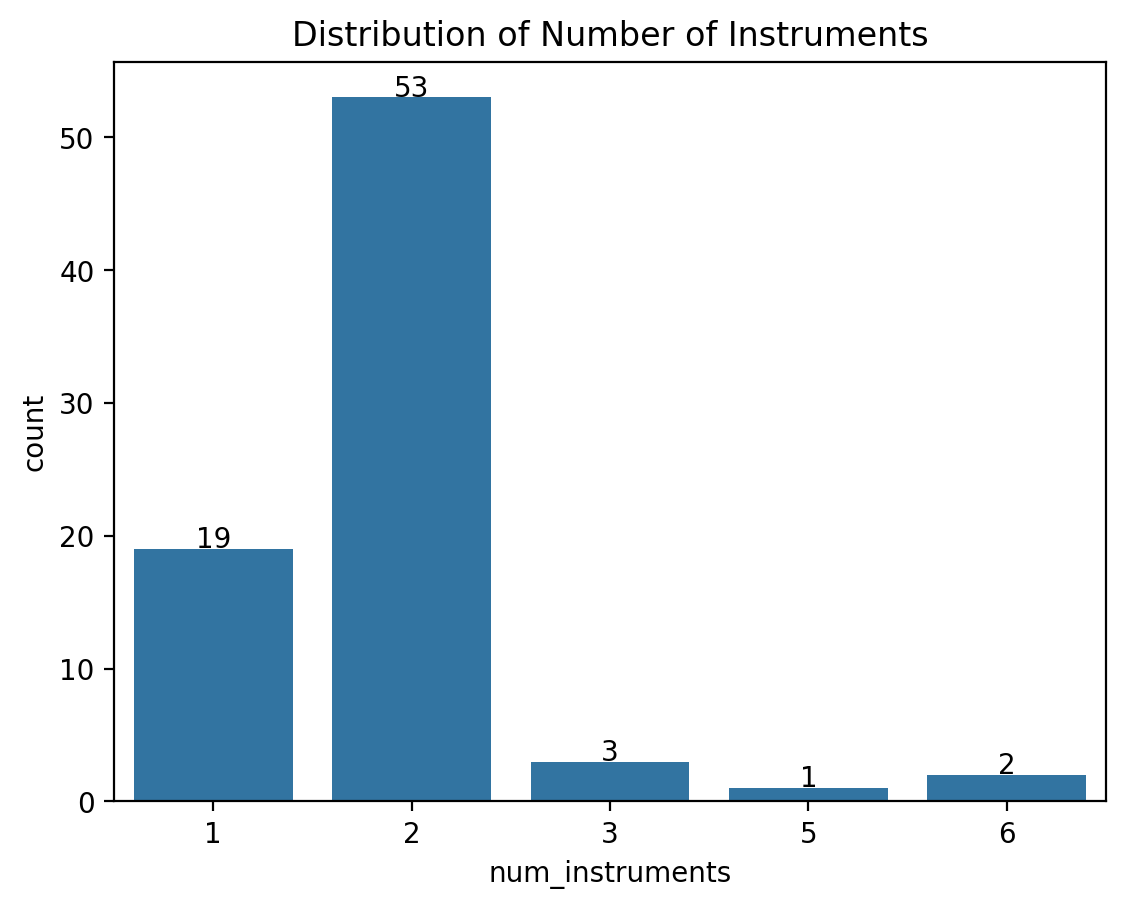

In [25]:
plot_instrument_distribution(midi_data)

In [26]:
midi_data['instruments'].unique()

array(['Acoustic Grand Piano'], dtype=object)

Instrument Number Analysis:

As we see in the graph above we contain 6 midi files where there is 3 or more instruments, we should only focus on the ones with two, so that the the model is not affected by other instruments instead of pianos

In [27]:
#Delete rows with 3 or more instruments
midi_data = midi_data[midi_data['num_instruments'] <= 2]

In [28]:
midi_data.head()

,filename,num_instruments,instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,avg_velocity,avg_duration,polyphony,avg_interval,pitch_classes,main_key,chords,notes
2,muss_3.mid,2,Acoustic Grand Piano,89.440365,310,2,8,67.607626,27,90,47.820418,0.355700,9.089856,0.106152,"[15, 86, 32, 140, 32, 65, 151, 28, 88, 25, 30,...",B major,"88.76, 49.65, 49.57, 64.68.71, 78.82.70.73, 66...","(68,0.00,0.64,77) (56,0.00,0.64,65) (54,0.64,1..."
3,muss_1.mid,2,Acoustic Grand Piano,210.571309,1036,2,21,56.749396,27,94,61.642512,0.438788,7.864319,0.126381,"[122, 47, 130, 245, 58, 232, 106, 127, 77, 144...",E- major,"65.74, 69.81, 77.65, 60.57.65, 75.67.70.79, 54...","(67,0.00,0.63,90) (65,0.60,1.22,85) (70,1.20,1..."
4,mendel_op19_3.mid,2,Acoustic Grand Piano,137.633716,430,1,1,65.702386,28,97,57.596902,0.186539,17.357665,0.057595,"[11, 436, 127, 73, 516, 5, 249, 1, 214, 448, 3...",A major,"76.73, 75.78, 69.81, 69.71, 88.76, 64.52, 52.5...","(64,0.57,1.32,70) (61,1.32,1.41,69) (64,1.41,1..."
5,schum_abegg.mid,2,Acoustic Grand Piano,370.867372,2705,3,6,68.073349,29,101,49.306569,0.214863,15.145576,0.065885,"[1013, 247, 484, 170, 520, 739, 153, 600, 226,...",F major,"76.73, 57.67, 84.86, 64.52, 77.86, 50.57, 84.9...","(69,0.75,1.27,45) (81,0.75,1.27,56) (82,1.27,1..."
6,gra_esp_4.mid,2,Acoustic Grand Piano,282.377630,759,3,7,63.857296,31,91,45.261358,0.538972,6.625879,0.150154,"[249, 7, 482, 31, 113, 51, 62, 387, 1, 183, 65...",G major,"65.74, 64.72, 77.65, 69.60, 58.74.67, 60.66.69...","(62,0.00,0.73,77) (59,0.00,0.73,64) (86,0.73,1..."


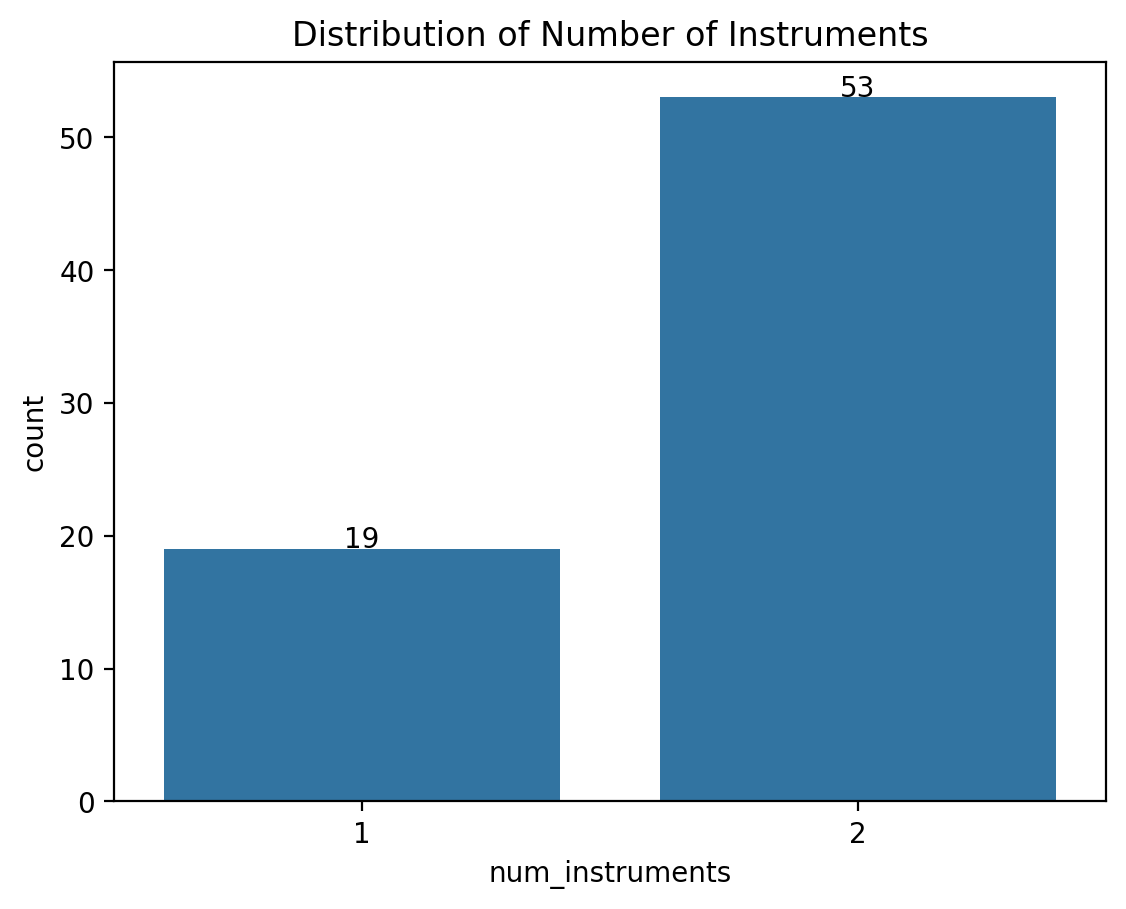

In [29]:
plot_instrument_distribution(midi_data)

In [30]:
#count how many different instruments are in the DF
midi_data['instruments'].nunique()

1

In [31]:
#what are the different instruments
midi_data['instruments'].unique()

array(['Acoustic Grand Piano'], dtype=object)

In [32]:
tota_notes= midi_data['notes'].apply(count_notes).sum()
#change format to be readable
tota_notes = "{:,}".format(tota_notes)
print(f"Total notes: {tota_notes}")

Total notes: 247,307


Now we have songs that contains only 2 or 1 instrument all of them being Acoustic Grand Piano

### Duration of the MIDI files

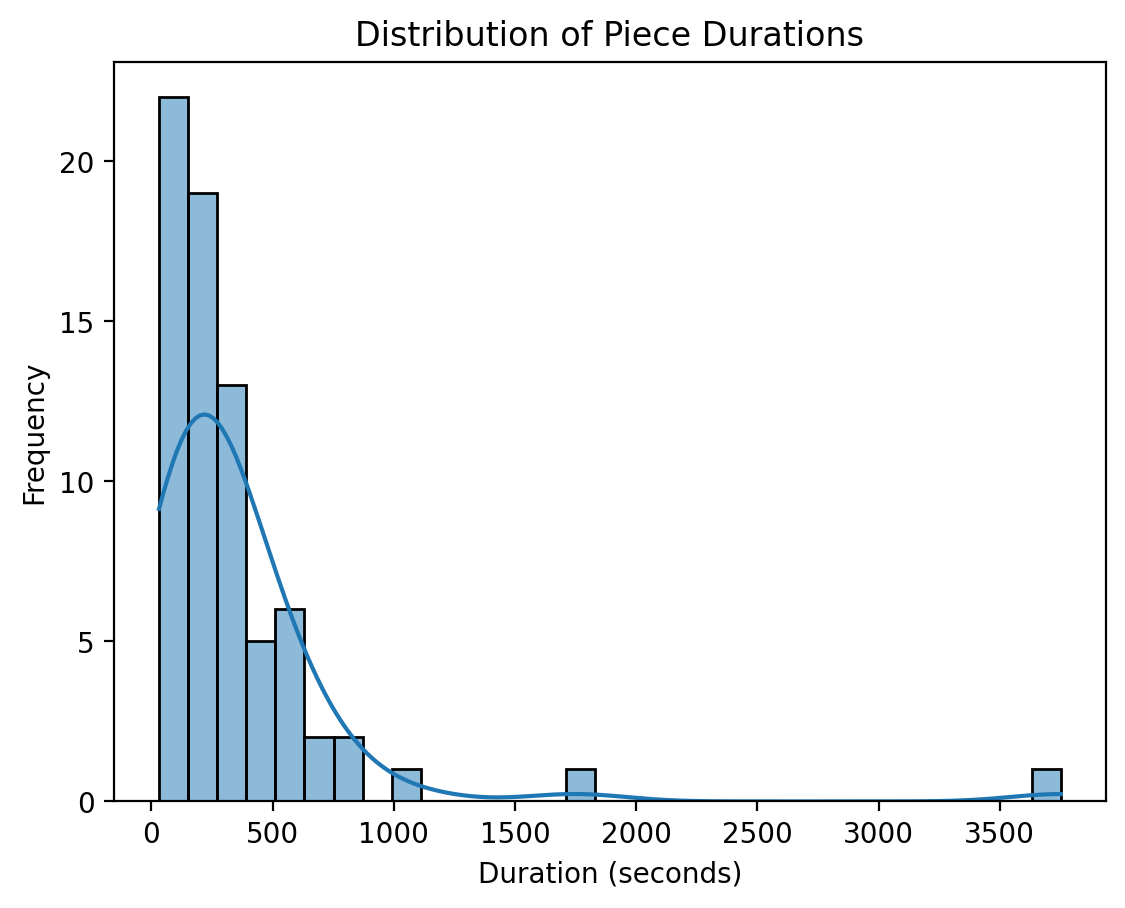

In [33]:
# Histogram of durations
sns.histplot(midi_data['duration'], kde=True)
plt.title('Distribution of Piece Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

From the graph, we can infer several things that are useful for training an RNN for music generation:

1. **Most Common Durations**: The majority of pieces are concentrated in the lower range of durations, particularly between 0 to 500 seconds. Shorter pieces are more prevalent in our dataset.

2. **Duration Variability**: There are fewer pieces with longer durations, but they do exist, indicating there is some variability in the dataset. This is important for the model to learn if we want it to generate pieces with varying lengths. There are a few pieces with much longer durations, around 3000 seconds and above. These are  outliers, and we decide to eliminate this in order for the model to have a better training


In [34]:
#DELETE OUTLIERS
midi_data = midi_data[midi_data['duration'] < 1000]

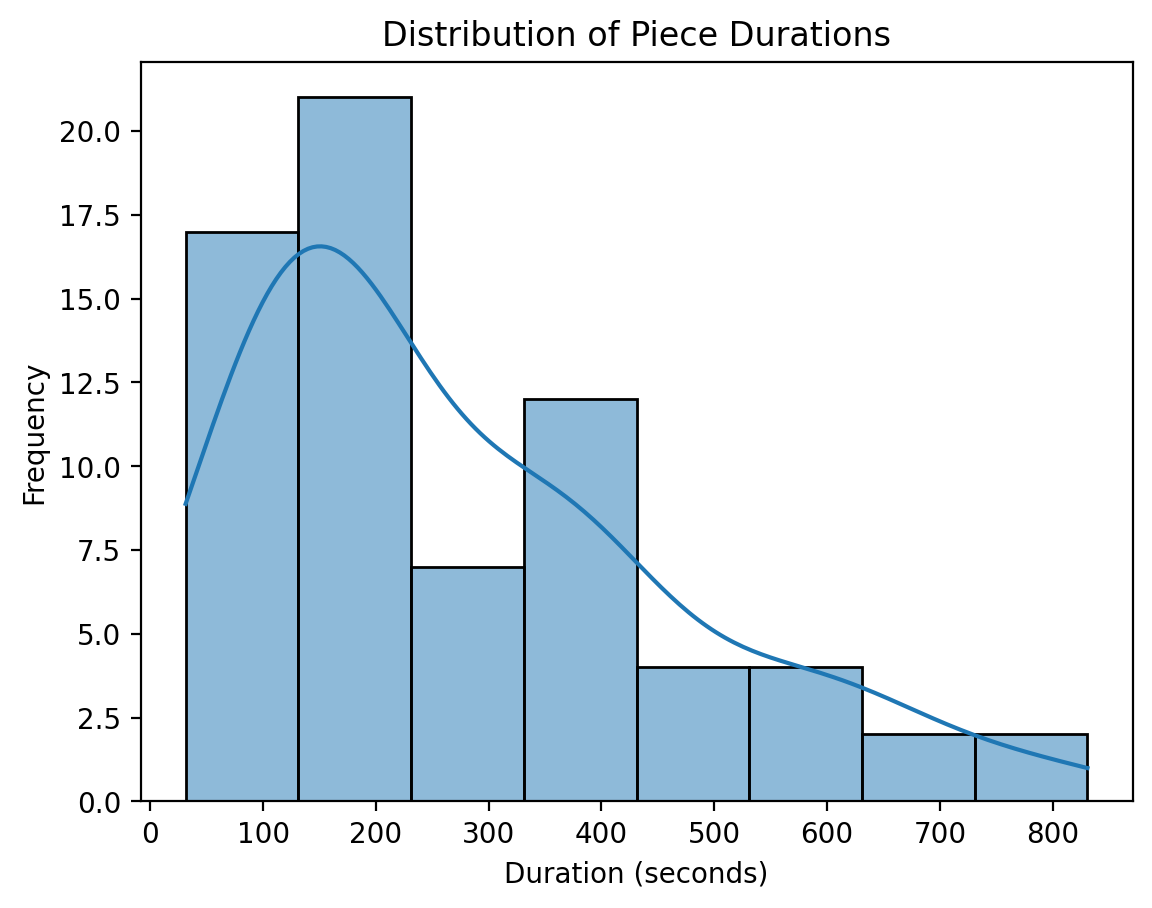

In [35]:
# Histogram of durations
sns.histplot(midi_data['duration'], kde=True)
plt.title('Distribution of Piece Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

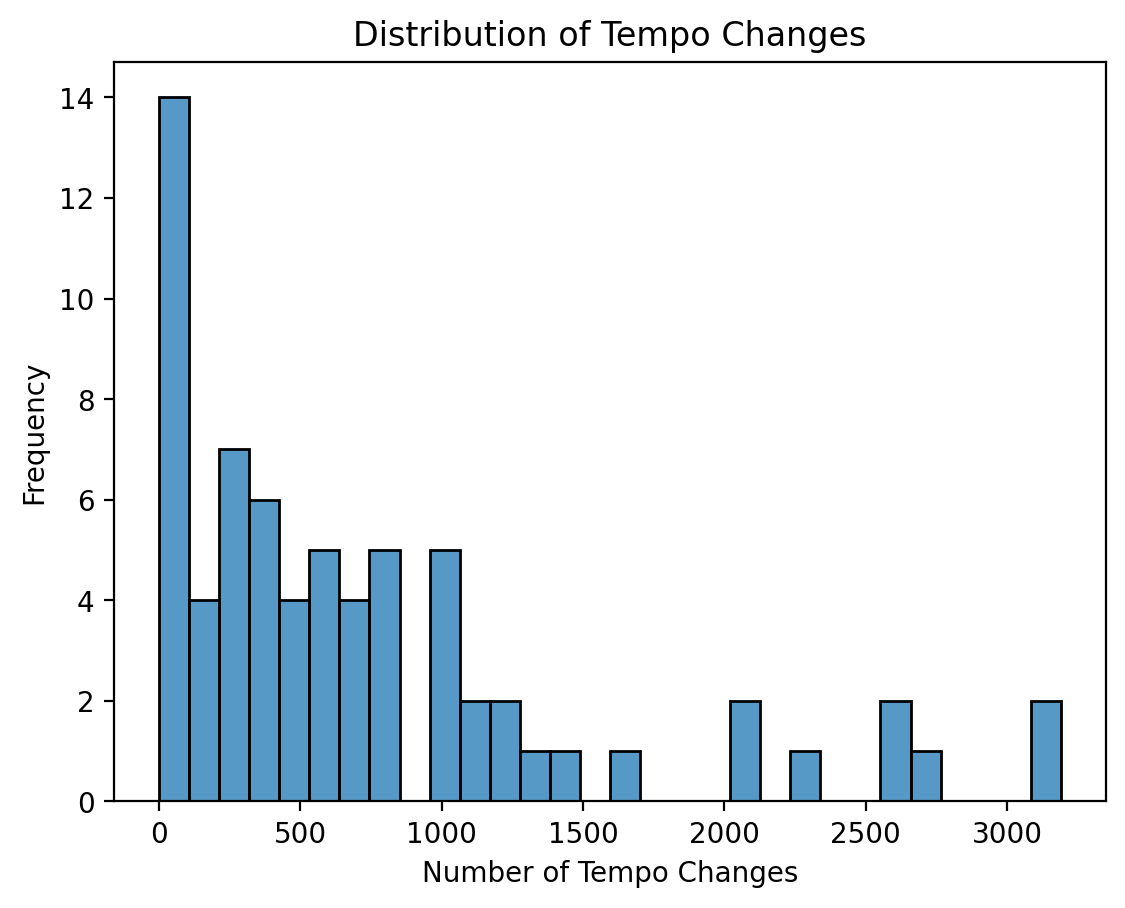

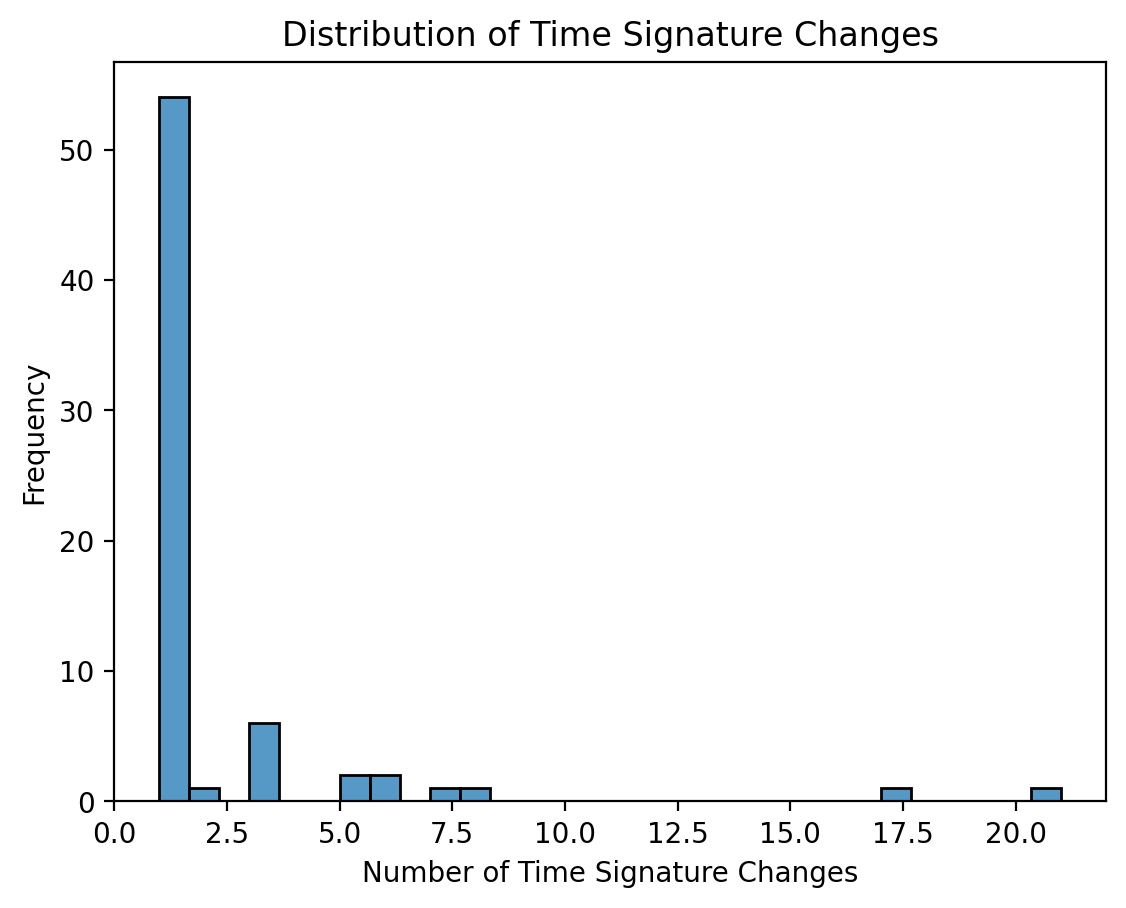

In [39]:
# Histogram of tempo changes
sns.histplot(midi_data['tempo_changes'], bins=30)
plt.title('Distribution of Tempo Changes')
plt.xlabel('Number of Tempo Changes')
plt.ylabel('Frequency')
plt.show()

# Histogram of time signature changes
sns.histplot(midi_data['time_signatures'], bins=30)
plt.title('Distribution of Time Signature Changes')
plt.xlabel('Number of Time Signature Changes')
plt.ylabel('Frequency')
plt.show()

### Distribution of Tempo Changes

1. **Sparse Tempo Changes**: Most pieces have few or no tempo changes, with a large frequency at 0. This indicates that tempo tends to remain constant throughout most pieces.
2. **Few Variations**: There are some pieces with a higher number of tempo changes, but these are less common. This could suggest that these pieces are more complex or have more movement and variation in terms of speed.
3. **Outliers**: Pieces with an extremely high number of tempo changes (e.g., over 2500) are rare. These might be specific types of compositions or outliers that you may want to examine further.

### Distribution of Time Signature Changes

1. **Stable Time Signatures**: Similar to tempo, most pieces have a stable time signature with no changes throughout the piece, which is indicated by the high frequency at 0.
2. **Occasional Variability**: A small number of pieces do have time signature changes, but they are not common. This might reflect specific genres or compositional styles where time signature changes are a characteristic feature.
3. **Rare Complexity**: Very few pieces have a large number of time signature changes, suggesting that such complexity is not common in the dataset.


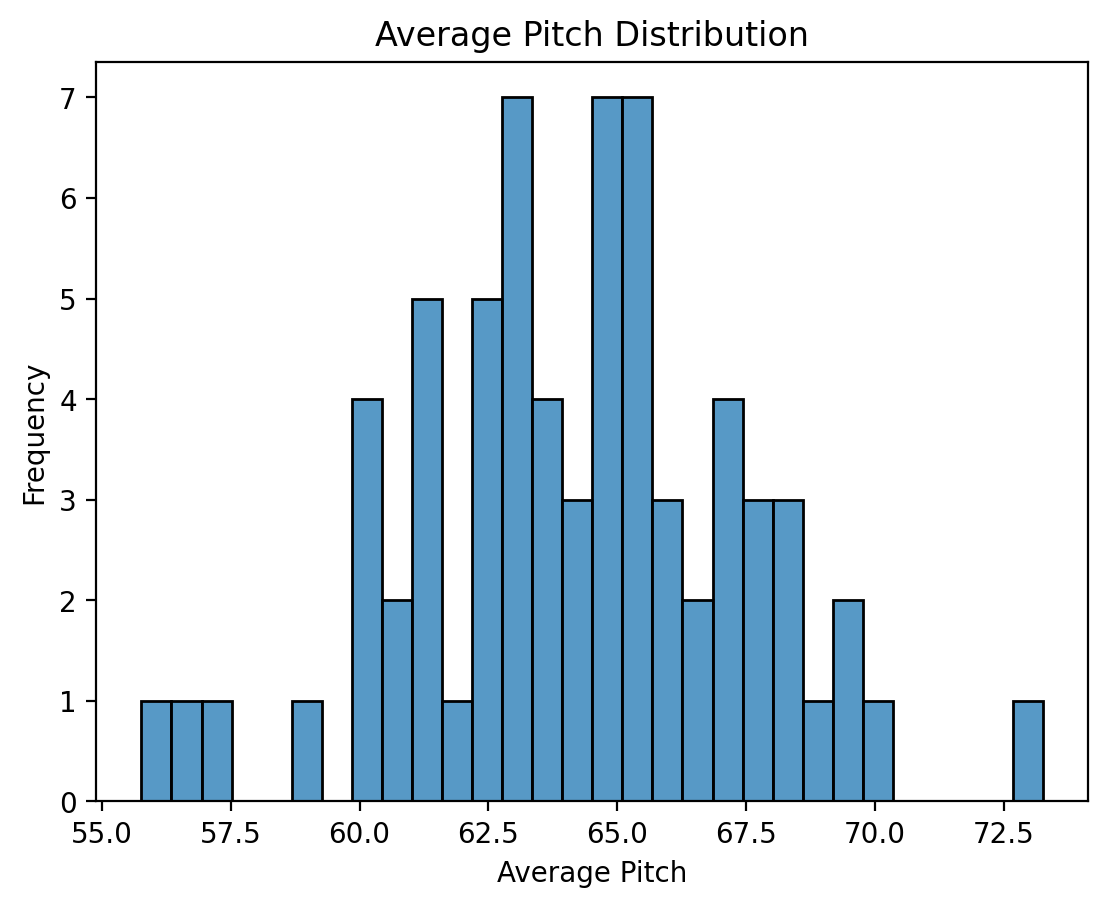

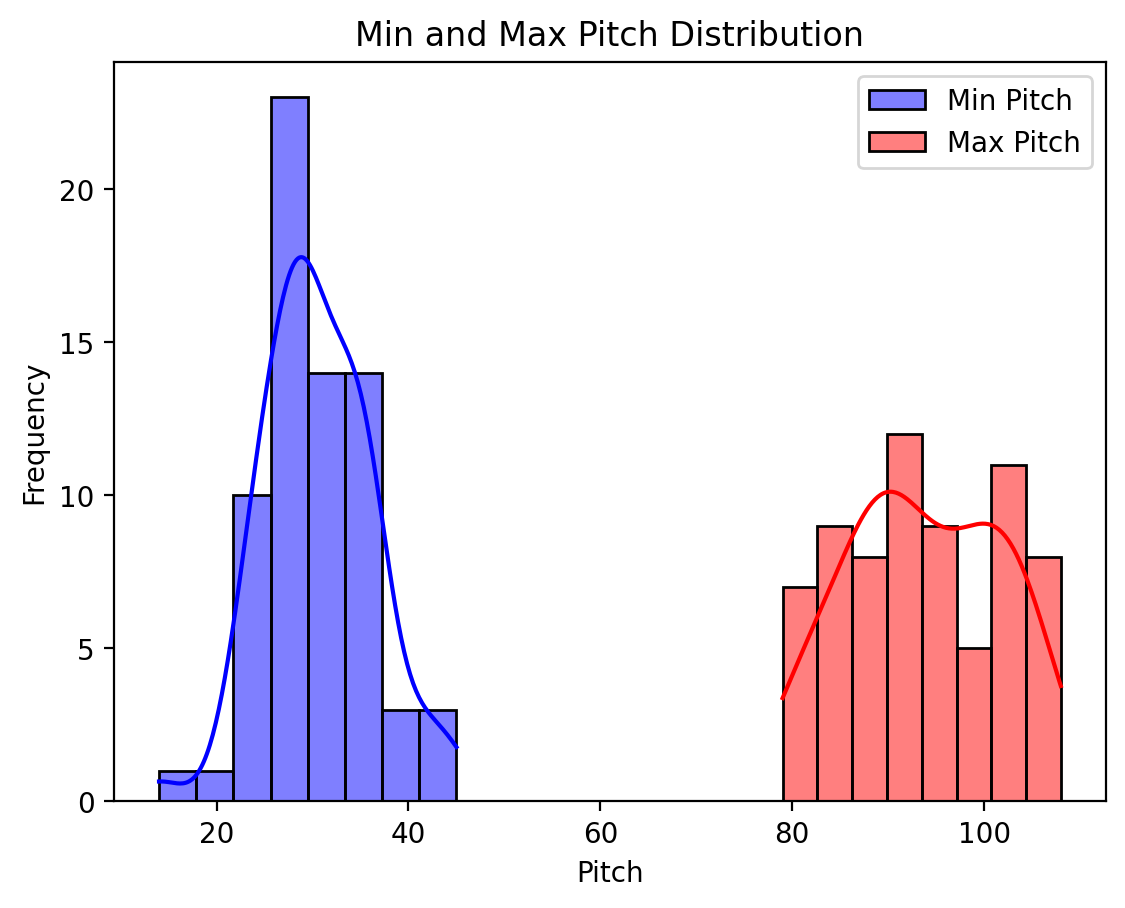

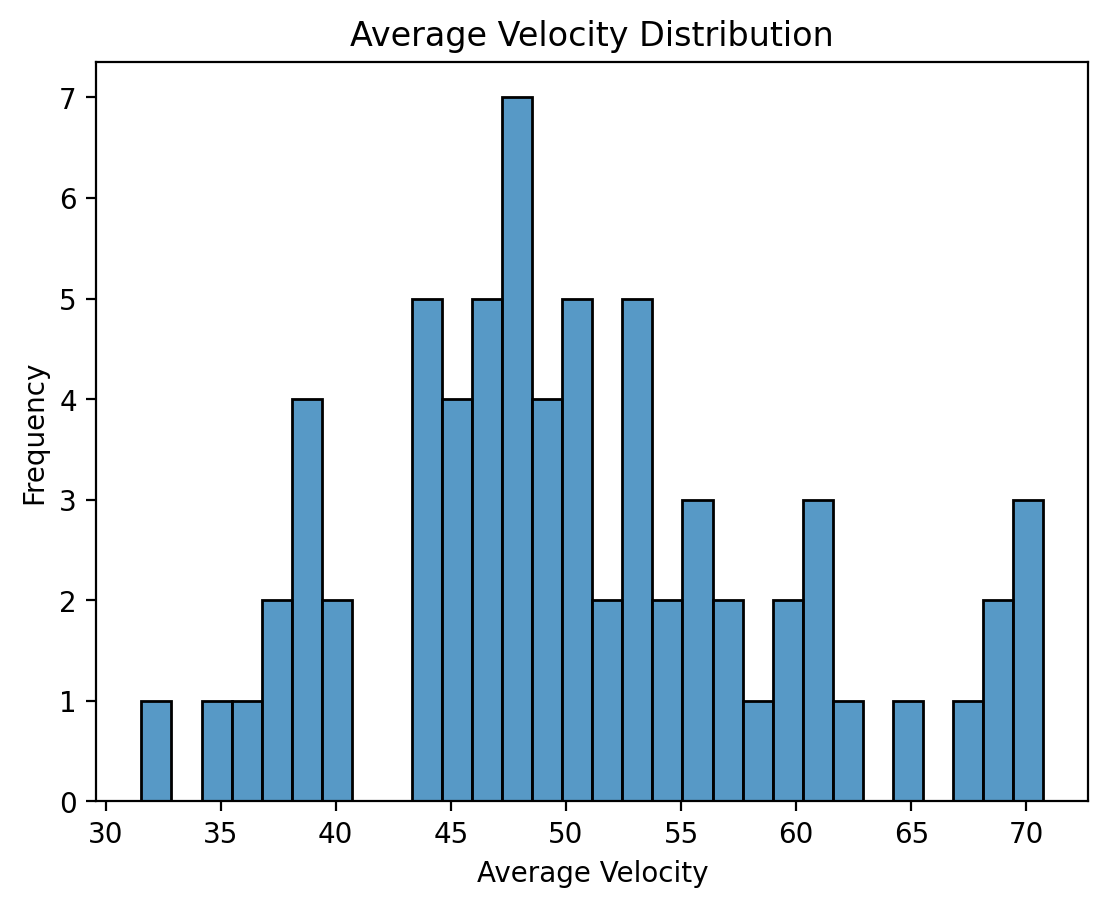

In [40]:
# Average Pitch Distribution
sns.histplot(midi_data['avg_pitch'], bins=30)
plt.title('Average Pitch Distribution')
plt.xlabel('Average Pitch')
plt.ylabel('Frequency')
plt.show()

# Min and Max Pitch Distribution
sns.histplot(midi_data['min_pitch'], color='blue', label='Min Pitch', kde=True)
sns.histplot(midi_data['max_pitch'], color='red', label='Max Pitch', kde=True)
plt.legend()
plt.title('Min and Max Pitch Distribution')
plt.xlabel('Pitch')
plt.ylabel('Frequency')
plt.show()

# Average Velocity Distribution
sns.histplot(midi_data['avg_velocity'], bins=30)
plt.title('Average Velocity Distribution')
plt.xlabel('Average Velocity')
plt.ylabel('Frequency')
plt.show()


### Average Pitch Distribution

- **Central Tendency**: The distribution appears to be somewhat uniform with multiple peaks, suggesting there isn't a single average pitch that dominates your dataset.
- **Range**: The average pitch values are spread out between 58 and 70, which corresponds to around the range of Bb1 to C#5 in scientific pitch notation. This suggests a mid-range concentration of pitches for your average values.

### Min and Max Pitch Distribution

- **Min Pitch**: The minimum pitch values are concentrated around the lower range (20-40), which suggests that most pieces have their lowest notes within the bass or lower tenor range.
- **Max Pitch**: The maximum pitch values are more spread out but have concentrations at both the lower and higher ranges. This indicates a variety in the highest notes across pieces, from mid-range to soprano pitches.

### Average Velocity Distribution

- **Variability in Dynamics**: The histogram shows a spread of average velocity values with several peaks. This implies variability in the dynamics across pieces, with no single dynamic level being overly dominant.
- **Mid-Range Dynamics**: Most pieces have an average velocity (dynamics) around the mid-range, indicating that neither very soft nor very loud dynamics overly dominate the dataset.

### Implications for RNN Music Generation:

- **Pitch Representation**: The RNN will need to learn a range of pitches that reflect the spread seen in the average pitch distribution. It should not bias towards any specific pitch range.
  
- **Dynamic Range**: The model should be able to generate notes with a range of dynamics, as indicated by the spread in the average velocity distribution.
  
- **Note Range**: The RNN should be capable of generating music that reflects the min and max pitch distributions, ensuring that compositions have realistic and varied pitch ranges.

- **Melodic Contour**: Given the spread of average pitches, the model should be trained to understand the contour of melodies which may not stick to a narrow pitch range.
  
- **Expressiveness**: The dynamics (velocity) of the music are an important part of its expressiveness. The model should learn to vary dynamics to reflect the diversity found in the dataset.

By ensuring your RNN considers the range and diversity of pitch and dynamics represented in your dataset, the generated music will likely be more varied and interesting, offering a more authentic and engaging listening experience.

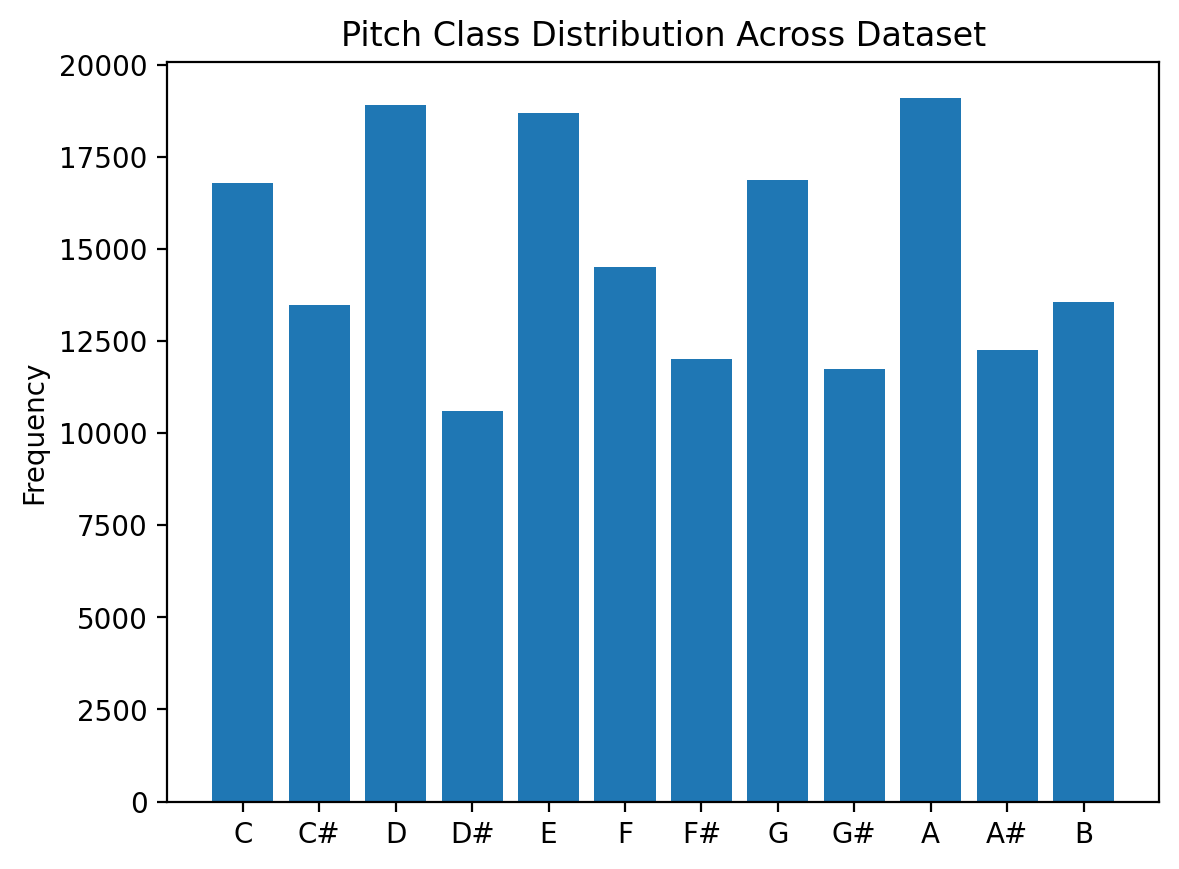

In [41]:
# Aggregate pitch class distributions from all files
total_pitch_classes = [0] * 12
for pc in midi_data['pitch_classes']:
    for i in range(12):
        total_pitch_classes[i] += pc[i]

# Plotting
fig, ax = plt.subplots()
ax.bar(range(12), total_pitch_classes)
ax.set_xticks(range(12))
ax.set_xticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
ax.set_title('Pitch Class Distribution Across Dataset')
ax.set_ylabel('Frequency')
plt.show()


The bar chart shows the frequency distribution of pitch classes across our dataset. Pitch classes refer to the set of all pitches that are a whole number of octaves apart, so in this context, C includes all C notes across all octaves, C# includes all C# notes, and so on.

Here are some conclusions we can draw from this chart:

1. **Pitch Preferences**: Some pitch classes are more frequently used than others. For instance, pitches C, D, and A seem to be used more often than other pitch classes like E and B. This could reflect a preference for certain keys or intervals in the compositions.

2. **Tonality**: The distribution might indicate a common tonality within the dataset. If C is the most frequent pitch class, the pieces might often be in keys related to C major or A minor (given that A is also quite common).

3. **Compositional Styles**: The frequency of certain pitch classes might reflect compositional styles or genre-specific tendencies. For example, jazz might have more chromatic notes, whereas folk music might center around a major scale with less chromaticism.

For your RNN model used for music generation:

- **Diversity of Learning**: Ensure the model learns from the variety of pitches. It might need to capture less frequent pitch classes to create a diverse range of music.
  
- **Model Bias**: Be cautious of any bias towards the more frequent pitch classes, which could lead your model to overuse them in generated compositions.
  
- **Key Signature Consideration**: When training the model, consider key signature as a feature, especially if the frequency of pitch classes suggests a bias towards certain keys.
  
- **Harmonization**: The RNN might learn to harmonize melodies using the most common pitch classes. Including a diverse set of harmonies in training could encourage more creativity in the model's output.

This graph gives a good indication of the melodic tendencies in your dataset, which can significantly influence the character and diversity of the music generated by your RNN.

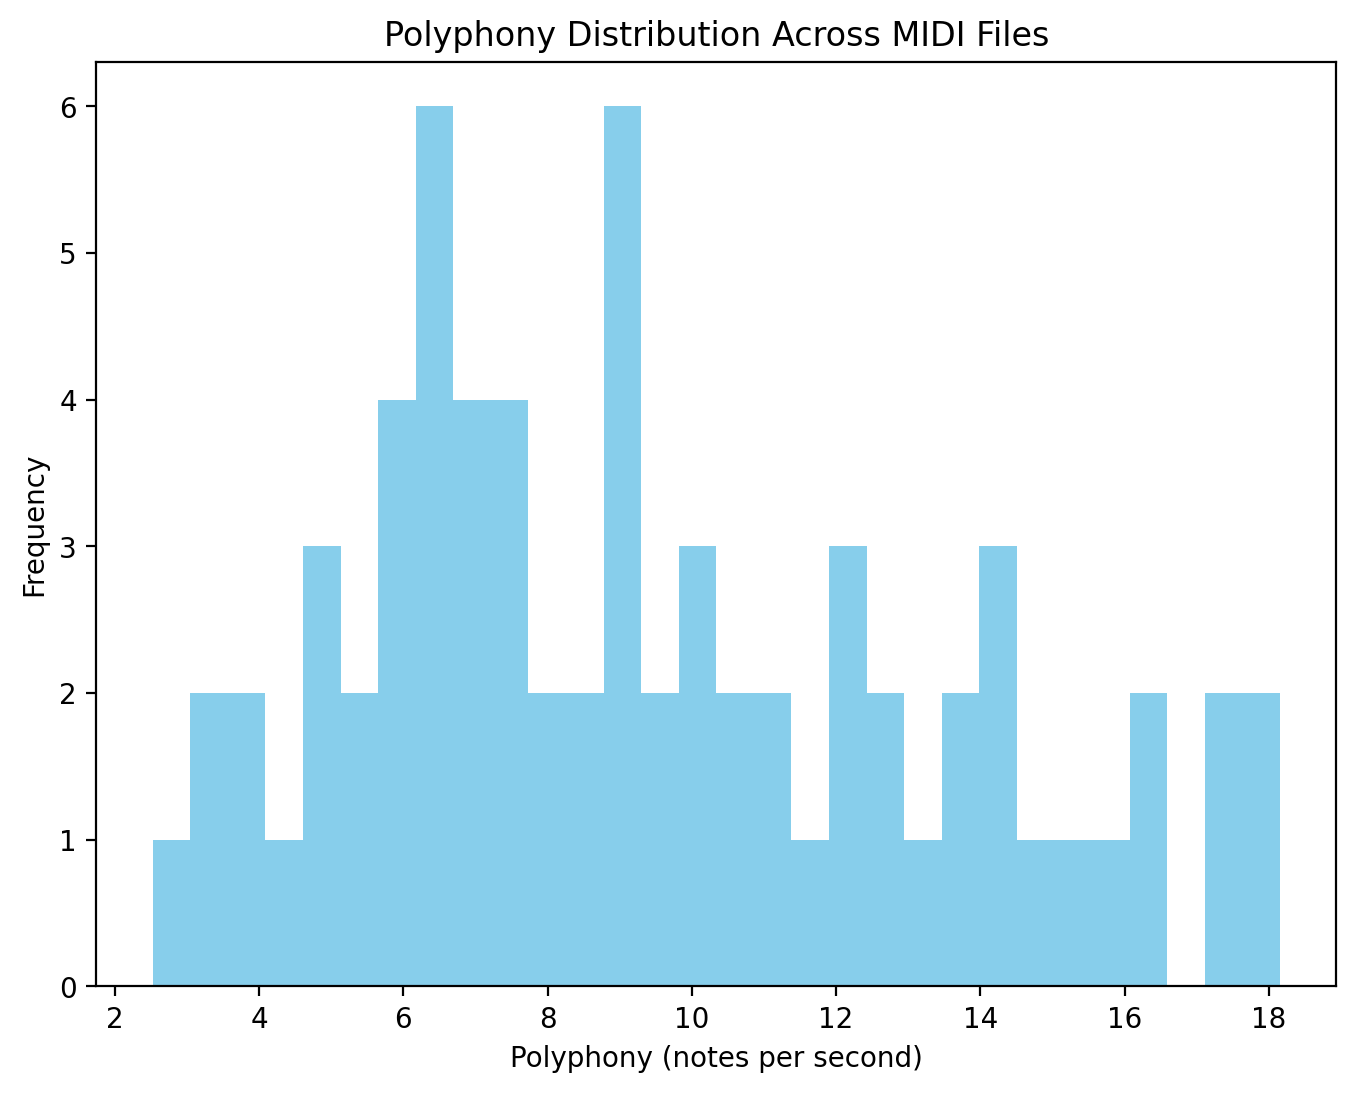

In [42]:
# Plotting the distribution of polyphony
plt.figure(figsize=(8, 6))
plt.hist(midi_data['polyphony'], bins=30, color='skyblue')
plt.title('Polyphony Distribution Across MIDI Files')
plt.xlabel('Polyphony (notes per second)')
plt.ylabel('Frequency')
plt.show()


This histogram shows the distribution of polyphony across MIDI files in our dataset, measured as the number of notes played per second. Here's what we can conclude:

1. **Variety in Texture**: The distribution indicates that there's a variety of textural complexity in the dataset. Pieces range from less polyphonic (simpler textures with fewer notes per second) to more polyphonic (complex textures with more notes per second).

2. **Most Common Polyphony**: There seems to be a concentration of pieces with a polyphony level around 8 to 10 notes per second, suggesting that this is a common texture in the dataset. 

3. **Rare Complex Textures**: Higher levels of polyphony (14 notes per second and beyond) are less common. This could indicate either the presence of complex passages within otherwise simpler pieces or a few pieces that are consistently complex throughout.

In the context of training an RNN for music generation:

- **Learning Textural Diversity**: Your model should be exposed to a range of polyphonic textures during training to learn how to generate both simple and complex textures.

- **Balancing the Dataset**: If your goal is to generate music with a similar polyphonic distribution, ensure that the training data is not biased towards a specific polyphony level, unless that bias reflects your desired output.

- **Complexity Handling**: The model might need to be more sophisticated (e.g., with more LSTM layers or units) to capture and generate the complexity seen in the more polyphonic pieces.

- **Representation of Polyphony**: Make sure your data representation allows the model to discern between simultaneous notes and sequential notes, as this is key to learning polyphonic structures.

This graph provides insights into the textural characteristics of the music in your dataset, which can guide the design and training of your RNN to ensure it can generate music with a similar range of polyphonic complexity.

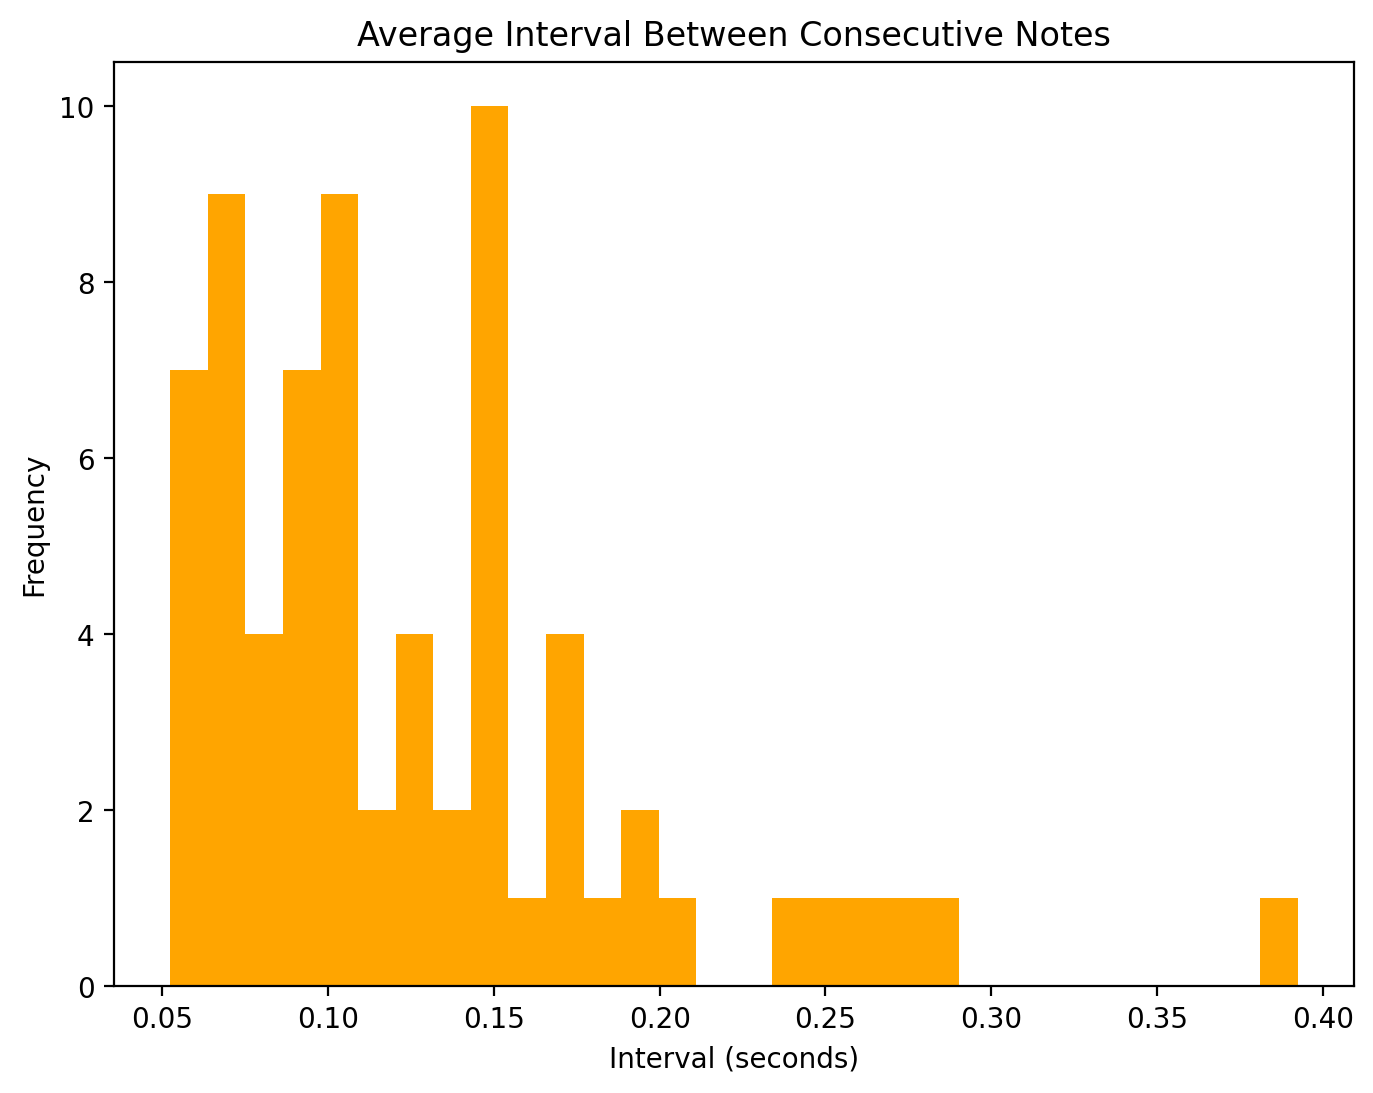

In [43]:
# Plotting the average interval between consecutive notes
plt.figure(figsize=(8, 6))
plt.hist(midi_data['avg_interval'], bins=30, color='orange')
plt.title('Average Interval Between Consecutive Notes')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.show()


The histogram depicts the distribution of the average interval between consecutive notes across MIDI files:

1. **Note Density**: Most pieces have an average interval between notes that is fairly short, mostly clustered around 0.10 to 0.15 seconds. This suggests a higher density of notes or faster rhythmic pacing in most of the music.

2. **Rhythmic Variation**: There's a spread of intervals up to 0.40 seconds, indicating some variety in rhythmic pacing. However, intervals longer than 0.20 seconds become increasingly less common.

For an RNN aimed at music generation:

- **Rhythmic Training**: The model should learn to generate notes with the more common shorter intervals to reflect the predominant rhythm patterns in the dataset.
- **Temporal Diversity**: It's also important for the RNN to capture the less common longer intervals for diversity in generated rhythms.
- **Time Step Consideration**: When designing the RNN, the time step should allow the network to capture the finer details of timing between notes, which means it should be shorter than the shortest interval in your data.
- **Expressiveness**: The variation in intervals could be related to expressive timing in performance, which is something the RNN may need to replicate for realistic music generation.

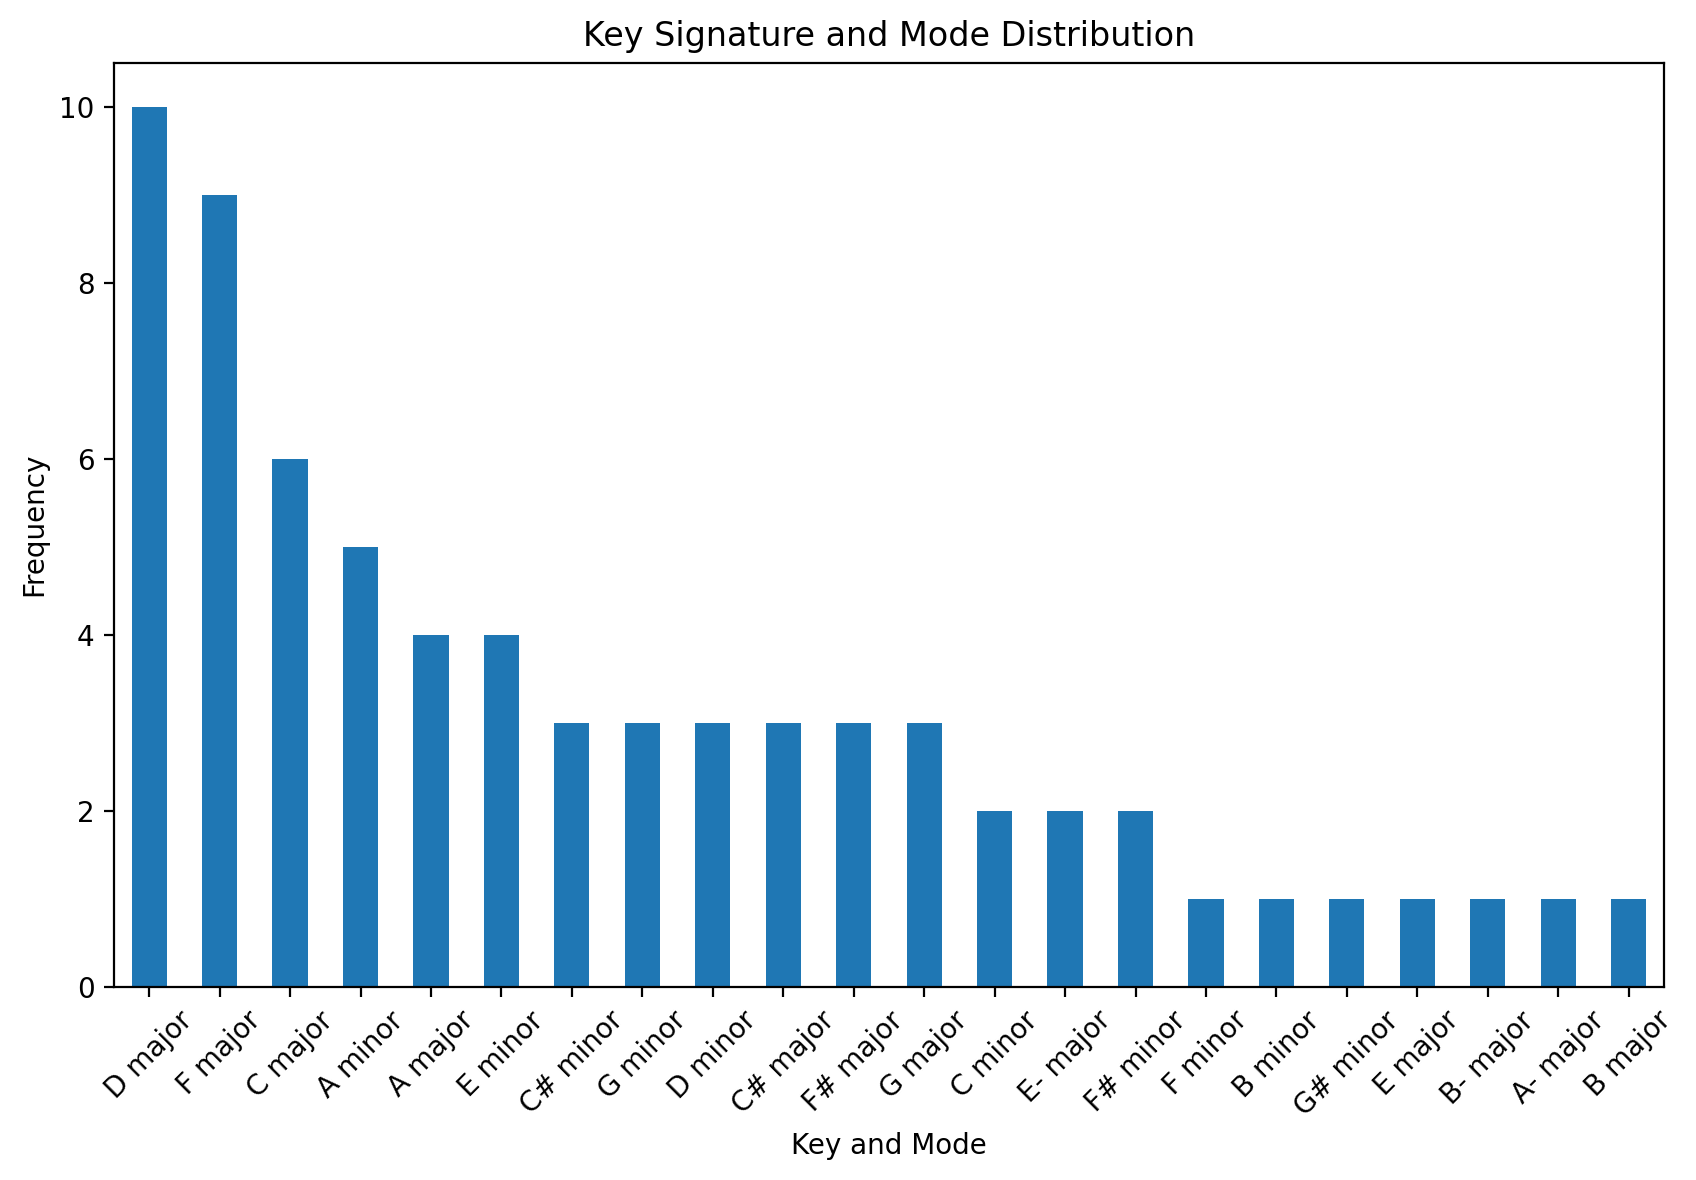

In [44]:
# Extracting key signatures and modes
keys = midi_data['main_key'].value_counts()

# Plotting
keys.plot(kind='bar', figsize=(10, 6))
plt.title('Key Signature and Mode Distribution')
plt.xlabel('Key and Mode')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


One of the main objectives of our model is to be able to generate a broad spectrum of music. So better for the model to have a broad number of keys and modes

The bar chart shows the frequency of various key signatures and modes in your dataset. From this, we can draw several conclusions:

1. **Key Popularity**: D major and F major are the most common keys, followed by C major and A major. This could indicate a preference for compositions in these keys within the dataset.

2. **Mode Distribution**: Major keys appear more frequently than minor keys, suggesting that the dataset may have a bias towards music with a major tonality, which is typically perceived as happier or brighter compared to the often sadder or more serious minor tonality.

3. **Musical Variety**: While some keys are clearly favored, there is representation across a range of key signatures and modes, indicating diversity in the dataset. However, some keys, like F# minor and A# minor, are less common, which could reflect their relative rarity in the repertoire or possibly the dataset's genre bias.

4. **Data Representation for Modeling**: For an RNN tasked with generating music, it's crucial that the model is exposed to a variety of keys during the training process to ensure that it doesn't overfit to the most common keys and is able to generalize and create music in any key.

5. **Transposition**: To prevent overfitting to certain keys and to ensure that the model can generalize well, you may consider transposing pieces into different keys as a form of data augmentation.

6. **Dataset Balance**: If the goal is to generate music that doesn't have a strong bias towards a particular key or set of keys, you may need to balance the dataset either by collecting more data in underrepresented keys or by using a weighted sampling method during training.

This distribution provides valuable insights into the tonal characteristics of the dataset and can help in making informed decisions about data preprocessing and model training for a music generation RNN.

In [45]:
# Extracting key signatures and modes
keys = midi_data['main_key'].value_counts()

print(keys)
print(sum(keys))


main_key
D major     10
F major      9
C major      6
A minor      5
A major      4
E minor      4
C# minor     3
G minor      3
D minor      3
C# major     3
F# major     3
G major      3
C minor      2
E- major     2
F# minor     2
F minor      1
B minor      1
G# minor     1
E major      1
B- major     1
A- major     1
B major      1
Name: count, dtype: int64
69


In [46]:
from collections import Counter

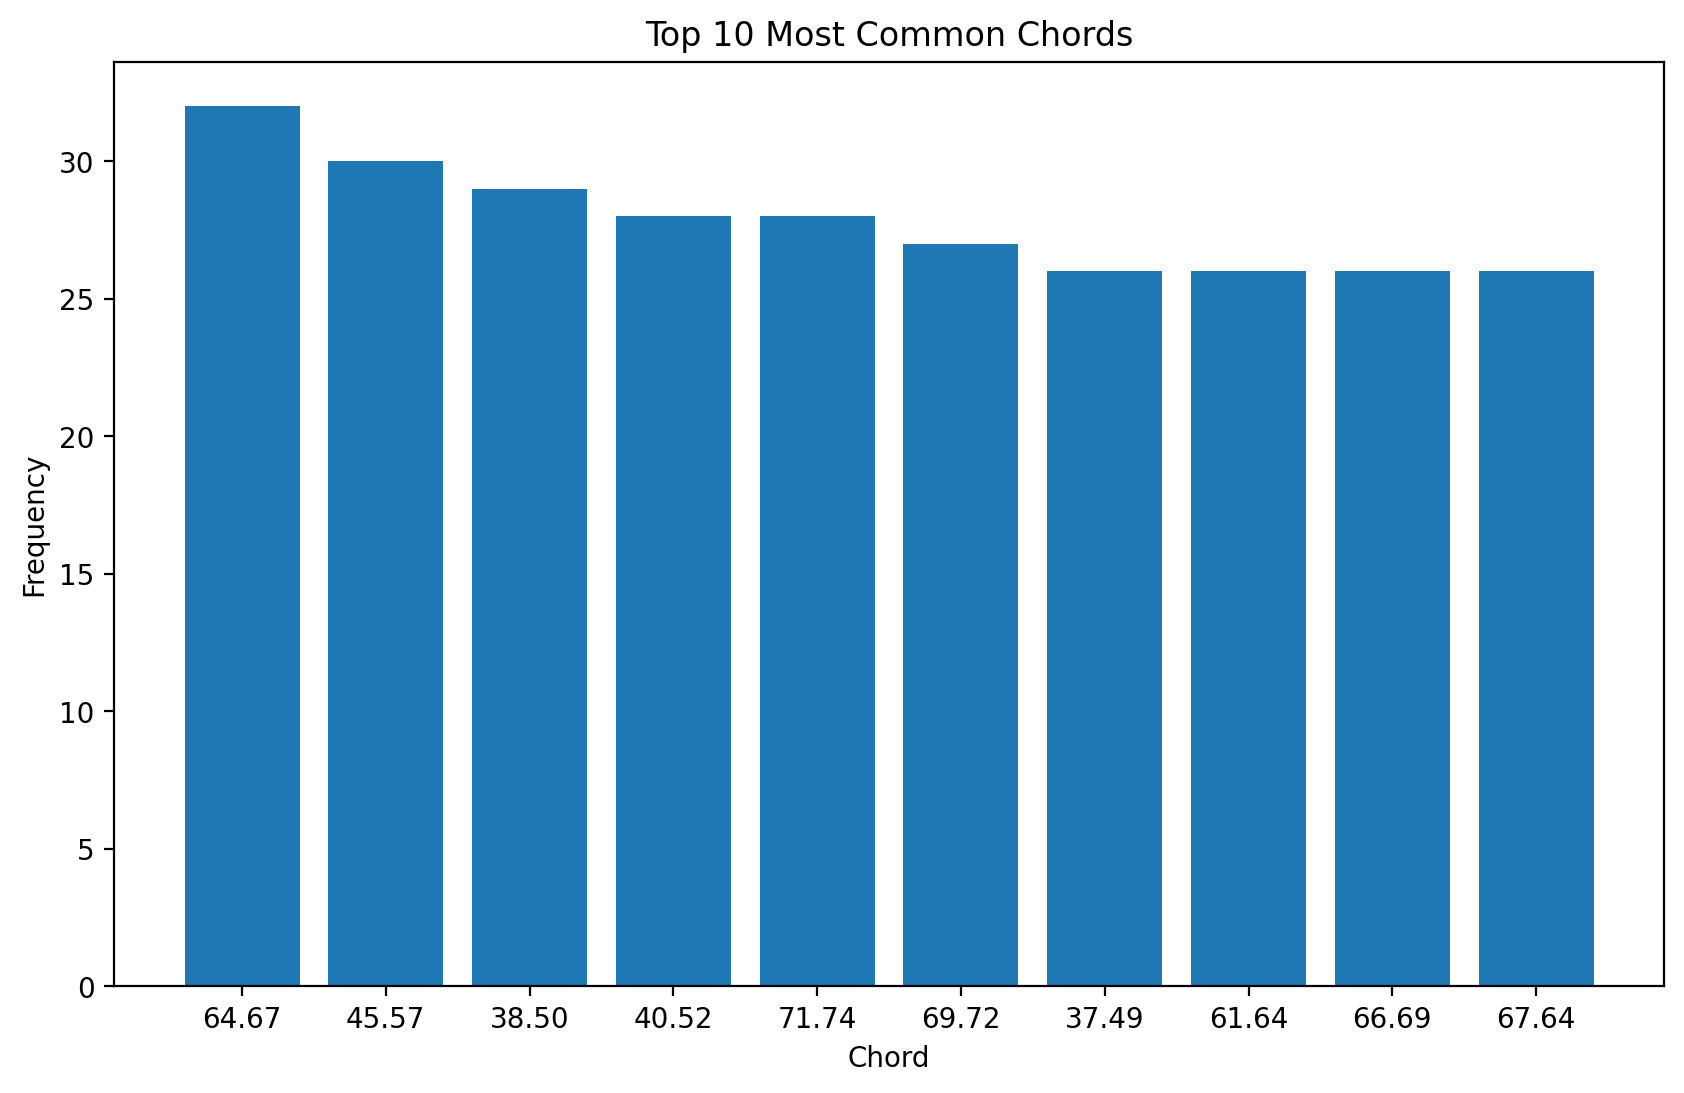

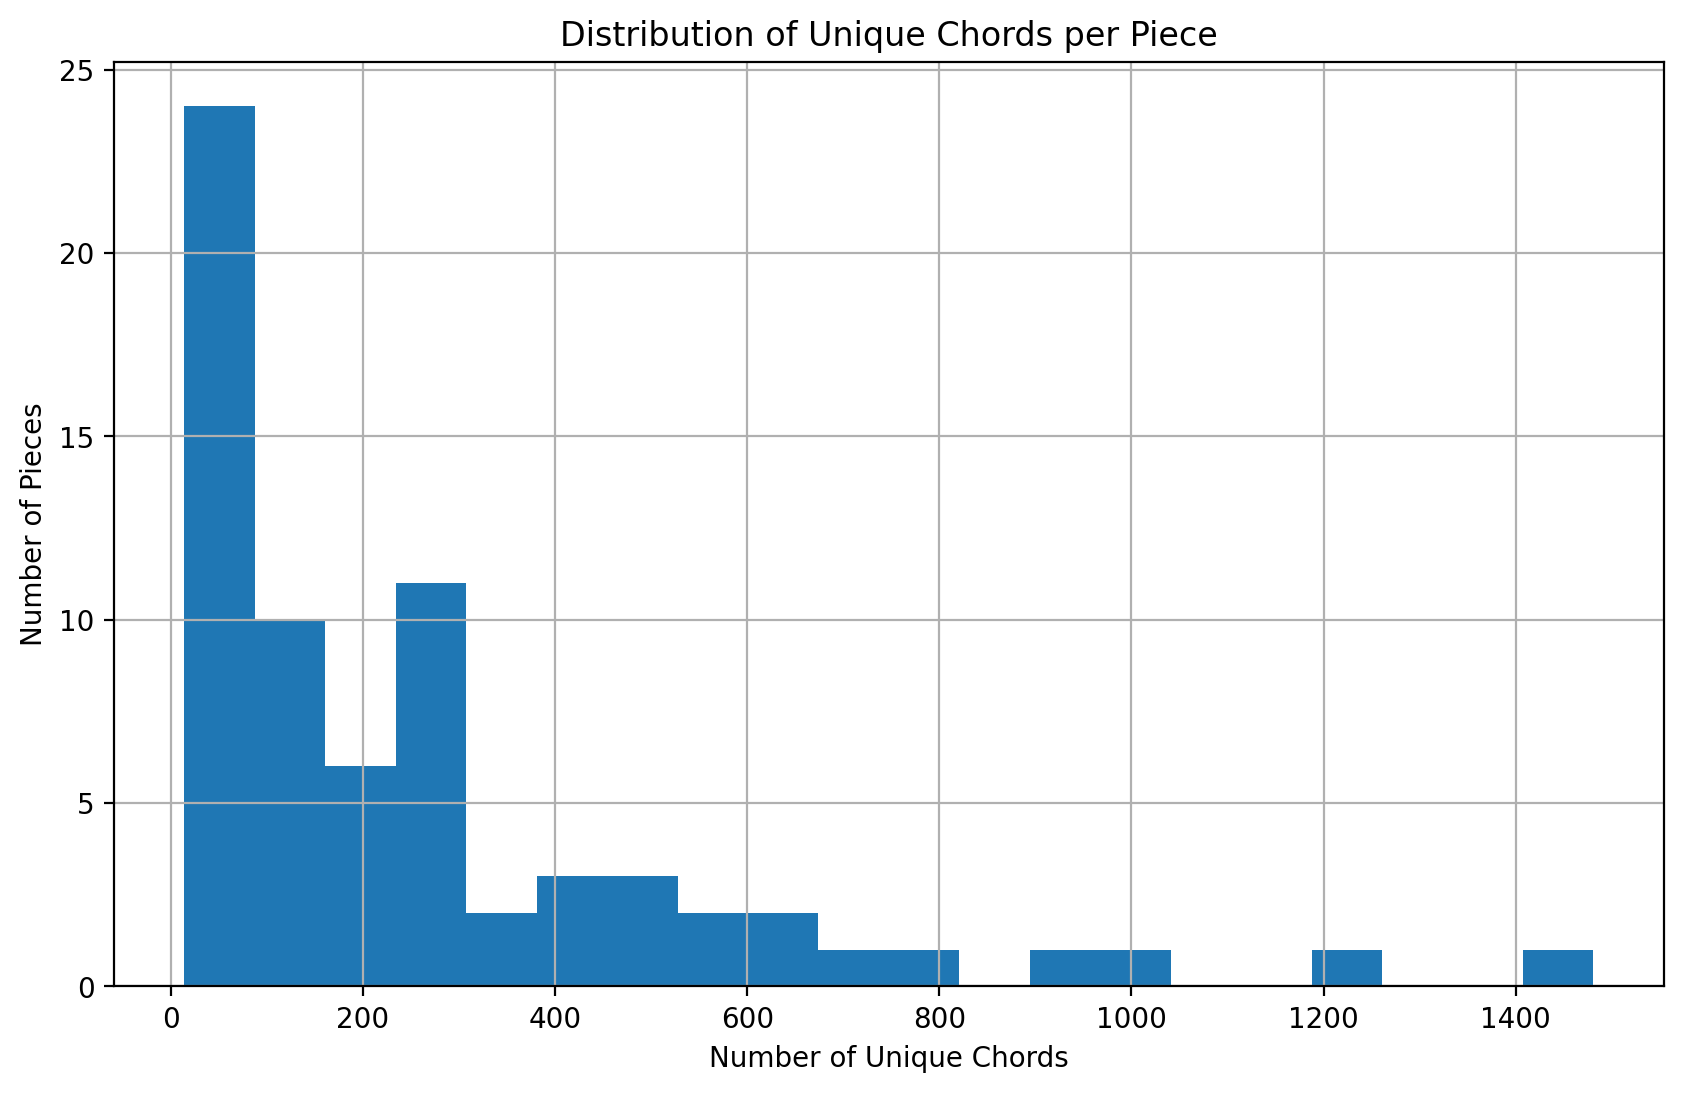

In [47]:

# Assuming `chords` column contains strings of unique chords separated by commas
midi_data['chord_list'] = midi_data['chords'].apply(lambda x: x.split(', '))

# Chord Frequency Distribution
all_chords = [chord for sublist in midi_data['chord_list'] for chord in sublist]
chord_counts = Counter(all_chords)
most_common_chords = chord_counts.most_common(10)  # Adjust as needed

# Plotting the most common chords
plt.figure(figsize=(10, 6))
plt.bar([chord[0] for chord in most_common_chords], [chord[1] for chord in most_common_chords])
plt.xlabel('Chord')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Chords')
plt.show()

# Chord Diversity per Piece
midi_data['unique_chords_count'] = midi_data['chord_list'].apply(len)
plt.figure(figsize=(10, 6))
midi_data['unique_chords_count'].hist(bins=20)
plt.xlabel('Number of Unique Chords')
plt.ylabel('Number of Pieces')
plt.title('Distribution of Unique Chords per Piece')
plt.show()

### Top 10 Most Common Chords
The first histogram displays the top 10 most common chords found in your dataset:

1. **Common Chord Preference**: There are a few chords that are clearly more prevalent than others. These chords likely represent common harmonic progressions in the genre(s) of music you're analyzing.
2. **Harmonic Diversity**: The distribution seems fairly even among these top chords, indicating there is no single chord that overwhelmingly dominates the dataset.

### Distribution of Unique Chords per Piece
The second histogram shows the number of unique chords used per music piece:

1. **Chord Variety**: Most pieces have a relatively low number of unique chords, suggesting a tendency towards simpler harmonic structures.
2. **Complex Harmonic Structures**: There are a few pieces with a very high number of unique chords, indicating more complex harmonic structures. These pieces could be from specific genres that favor intricate chord progressions or pieces that are longer and thus have more room for varied chord progressions.

For an RNN tasked with music generation:

- **Harmonic Simplicity**: If the RNN is trained predominantly on pieces with fewer unique chords, it may learn to generate music that has simpler harmonic structures, which could be desirable for certain genres.
- **Harmonic Complexity**: The presence of pieces with many unique chords suggests that it would also be beneficial for the RNN to learn from these examples to generate more complex and interesting harmonic progressions.
- **Genre Representation**: Ensure the training dataset represents the genre(s) you wish to generate music for. If you want more complex music, you may need to ensure the RNN has enough examples of such pieces.
- **Diversity in Generation**: To prevent the RNN from overfitting to the most common chords, consider introducing randomness or encouraging exploration during training so that it learns to use a variety of chords in its compositions.

In conclusion, your dataset contains a mix of harmonic simplicity and complexity, which should inform the way you train your RNN for music generation. If you wish to generate music that is representative of the dataset's diversity, your model should be exposed to the full range of harmonic structures present in the training data.

In [49]:
# Set the style for seaborn plots
sns.set_style("whitegrid")

def plot_descriptive_statistics(data):
    desc_stats = data.describe().transpose()
    print(desc_stats[['mean', 'std', '50%', 'min', 'max']])
    
    # Conclusions can be drawn by observing the mean, standard deviation, and median values to understand the central tendency
    # and dispersion of the data. Min and max values help id

In [50]:
plot_descriptive_statistics(midi_data)

                           mean         std         50%        min  \
num_instruments        1.768116    0.425127    2.000000   1.000000   
duration             274.428700  189.653030  206.069698  31.358879   
tempo_changes        737.202899  795.040927  458.000000   1.000000   
key_signatures         1.652174    2.106196    1.000000   0.000000   
time_signatures        2.159420    3.332651    1.000000   1.000000   
avg_pitch             64.194784    3.231450   64.350264  55.765983   
min_pitch             30.623188    5.662315   29.000000  14.000000   
max_pitch             93.739130    7.927339   93.000000  79.000000   
avg_velocity          50.636197    9.132057   49.306569  31.555907   
avg_duration           0.364907    0.215766    0.314813   0.084478   
polyphony              9.476499    4.034015    9.089856   2.522720   
avg_interval           0.126151    0.063881    0.108524   0.052422   
unique_chords_count  264.985507  292.676819  163.000000  14.000000   

                   

In [51]:
def plot_correlations(data):
    
    corr = data.select_dtypes(include=['float64', 'int64']).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')

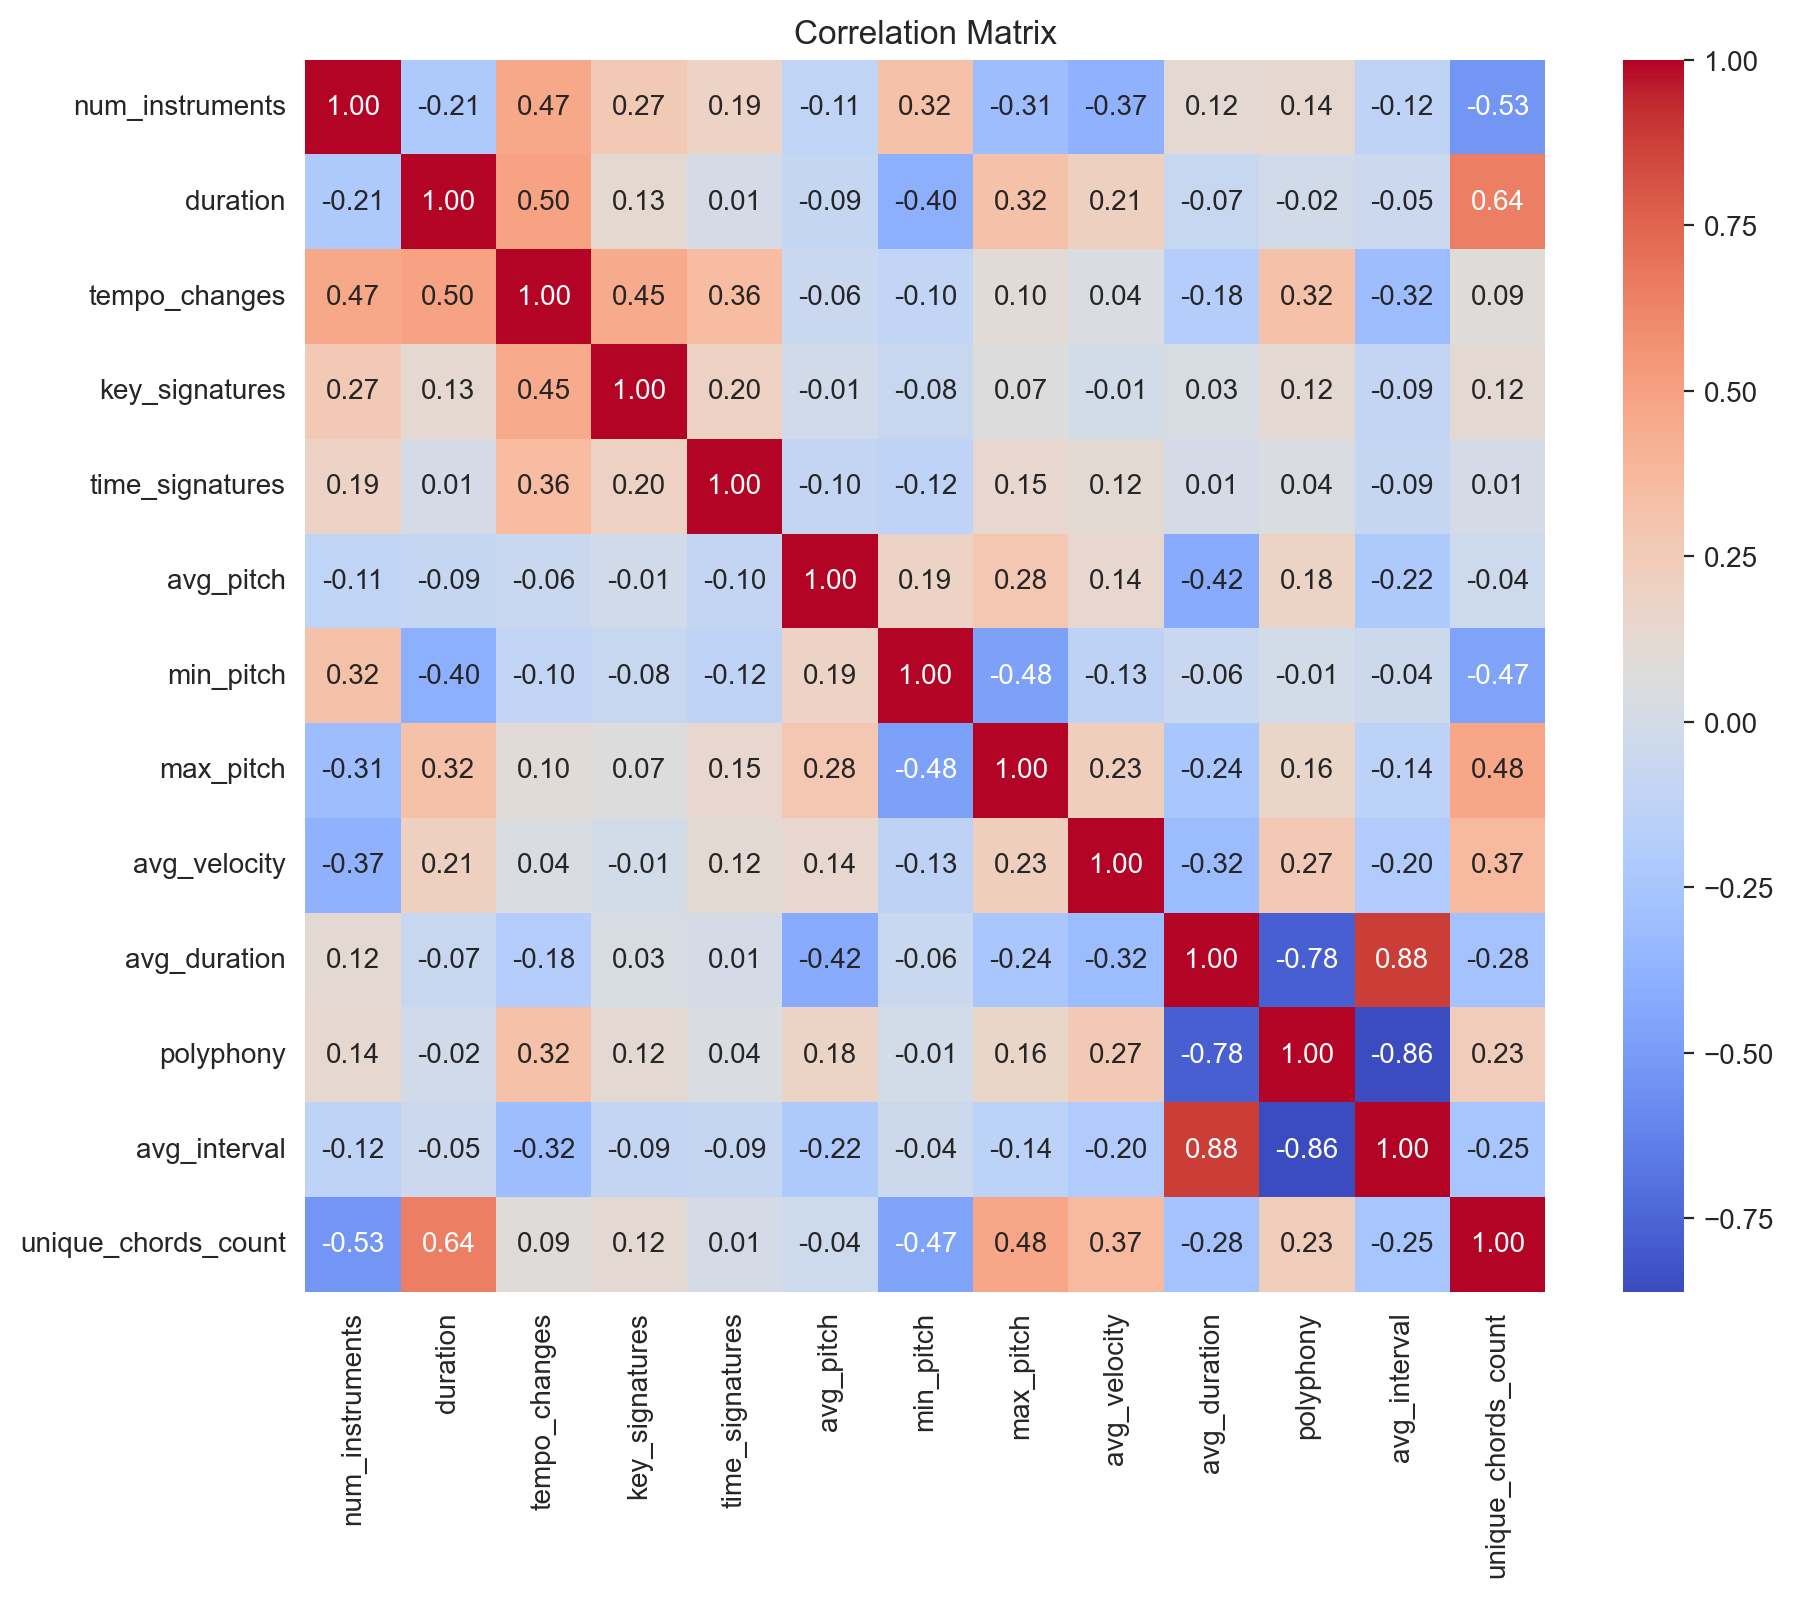

In [52]:
plot_correlations(midi_data)

Based on the correlation matrix, here are some conclusions we can draw:

1. **Negative Correlations**:
    - `num_instruments` and `avg_pitch`: A slight negative correlation (-0.25) suggests that pieces with more instruments tend to have a lower average pitch.
    - `min_pitch` and `max_pitch`: There is a strong negative correlation (-0.61) indicating that pieces with a higher minimum pitch tend to have a lower maximum pitch, and vice versa.
    - `avg_duration` and `polyphony`: A very strong negative correlation (-0.78) suggests that pieces with longer average note durations tend to have less polyphony, meaning fewer simultaneous notes.
    - `avg_duration` and `avg_interval`: Also a very strong negative correlation (-0.86) indicating that longer average note durations correspond with shorter intervals between notes.

2. **Positive Correlations**:
    - `duration` and `tempo_changes`: There is no significant correlation, indicating that the length of a piece does not necessarily correspond with the number of tempo changes.
    - `tempo_changes` and `key_signatures`, and `tempo_changes` and `time_signatures`: Moderate positive correlations (0.36 for both) suggest that pieces with more tempo changes also tend to have more key and time signature changes.
    - `avg_velocity` and `polyphony`: A moderate positive correlation (0.30) implies that pieces with louder notes (higher velocity) tend to have more polyphony.
    - `avg_duration` and `avg_interval`: A very strong positive correlation (0.89) suggests that pieces with longer average note durations also tend to have longer intervals between notes.

3. **No Significant Correlation**:
    - Several pairs of features, such as `num_instruments` and `duration` (-0.22), do not show a strong correlation, indicating no significant linear relationship between these variables.

The strong negative correlation between `avg_duration` and `polyphony` could suggest that when designing a model for music generation, if the goal is to produce pieces with rich polyphony, it might be beneficial to favor shorter note durations. The lack of correlation between `num_instruments` and `duration` might imply that the complexity of the piece in terms of instrumentation does not dictate its length, which could be an interesting insight for generating music with varying lengths without concern for the number of instruments involved.

# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Data Encoding</p>

### Enconding the notes

The first thing we need to do is extract from the column notes, the pitches, start time, duration and velocities

In [56]:
from ast import literal_eval
def parse_midi_note_data(note_str):
    """Parse MIDI note data from a single note string representation."""
    notes_list = [literal_eval(f"({note_repr})") for note_repr in note_str.split(')') if note_repr.strip()]
    pitches = [note[0] for note in notes_list]
    start_times = [note[1] for note in notes_list]
    durations = [note[2] - note[1] for note in notes_list]
    velocities = [note[3] for note in notes_list]
    return pitches, start_times, durations, velocities


In [59]:
#Parse note data
parsed_notes_series = midi_data['notes'].apply(parse_midi_note_data)

In [60]:
midi_data['pitches'], midi_data['start_times'], midi_data['durations'], midi_data['velocities'] = zip(*parsed_notes_series)


In [61]:
midi_data.head()

,filename,num_instruments,instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,...,pitch_classes,main_key,chords,notes,chord_list,unique_chords_count,pitches,start_times,durations,velocities
2,muss_3.mid,2,Acoustic Grand Piano,89.440365,310,2,8,67.607626,27,90,...,"[15, 86, 32, 140, 32, 65, 151, 28, 88, 25, 30,...",B major,"88.76, 49.65, 49.57, 64.68.71, 78.82.70.73, 66...","(68,0.00,0.64,77) (56,0.00,0.64,65) (54,0.64,1...","[88.76, 49.65, 49.57, 64.68.71, 78.82.70.73, 6...",93,"[68, 56, 54, 66, 71, 59, 73, 61, 78, 66, 75, 6...","[0.0, 0.0, 0.64, 0.64, 1.29, 1.29, 1.92, 1.92,...","[0.64, 0.64, 0.65, 0.65, 0.6299999999999999, 0...","[77, 65, 64, 76, 77, 65, 78, 66, 67, 56, 75, 6..."
3,muss_1.mid,2,Acoustic Grand Piano,210.571309,1036,2,21,56.749396,27,94,...,"[122, 47, 130, 245, 58, 232, 106, 127, 77, 144...",E- major,"65.74, 69.81, 77.65, 60.57.65, 75.67.70.79, 54...","(67,0.00,0.63,90) (65,0.60,1.22,85) (70,1.20,1...","[65.74, 69.81, 77.65, 60.57.65, 75.67.70.79, 5...",188,"[67, 65, 70, 72, 77, 74, 72, 77, 74, 70, 72, 6...","[0.0, 0.6, 1.2, 1.79, 2.08, 2.37, 2.96, 3.24, ...","[0.63, 0.62, 0.6100000000000001, 0.31000000000...","[90, 85, 89, 91, 81, 86, 85, 81, 85, 86, 86, 8..."
4,mendel_op19_3.mid,2,Acoustic Grand Piano,137.633716,430,1,1,65.702386,28,97,...,"[11, 436, 127, 73, 516, 5, 249, 1, 214, 448, 3...",A major,"76.73, 75.78, 69.81, 69.71, 88.76, 64.52, 52.5...","(64,0.57,1.32,70) (61,1.32,1.41,69) (64,1.41,1...","[76.73, 75.78, 69.81, 69.71, 88.76, 64.52, 52....",192,"[64, 61, 64, 69, 73, 76, 73, 76, 81, 85, 76, 8...","[0.57, 1.32, 1.41, 1.5, 1.6, 1.7, 2.45, 2.54, ...","[0.7500000000000001, 0.08999999999999986, 0.09...","[70, 69, 72, 75, 77, 85, 73, 77, 80, 81, 67, 7..."
5,schum_abegg.mid,2,Acoustic Grand Piano,370.867372,2705,3,6,68.073349,29,101,...,"[1013, 247, 484, 170, 520, 739, 153, 600, 226,...",F major,"76.73, 57.67, 84.86, 64.52, 77.86, 50.57, 84.9...","(69,0.75,1.27,45) (81,0.75,1.27,56) (82,1.27,1...","[76.73, 57.67, 84.86, 64.52, 77.86, 50.57, 84....",469,"[69, 81, 82, 70, 88, 76, 91, 79, 79, 91, 80, 6...","[0.75, 0.75, 1.27, 1.27, 1.7, 1.7, 2.09, 2.09,...","[0.52, 0.52, 0.42999999999999994, 0.4299999999...","[45, 56, 59, 48, 63, 51, 67, 54, 56, 69, 63, 5..."
6,gra_esp_4.mid,2,Acoustic Grand Piano,282.377630,759,3,7,63.857296,31,91,...,"[249, 7, 482, 31, 113, 51, 62, 387, 1, 183, 65...",G major,"65.74, 64.72, 77.65, 69.60, 58.74.67, 60.66.69...","(62,0.00,0.73,77) (59,0.00,0.73,64) (86,0.73,1...","[65.74, 64.72, 77.65, 69.60, 58.74.67, 60.66.6...",103,"[62, 59, 86, 62, 59, 86, 59, 62, 86, 62, 59, 8...","[0.0, 0.0, 0.73, 1.43, 1.43, 2.16, 2.84, 2.84,...","[0.73, 0.73, 0.3500000000000001, 0.73000000000...","[77, 64, 70, 65, 55, 62, 50, 59, 57, 51, 43, 4..."


In [62]:
# Step 1: One-hot Encoding for Pitches
def one_hot_encode_pitches(pitches):
    unique_pitches = sorted(set(pitch for sublist in pitches for pitch in sublist))
    pitch_to_index = {pitch: i for i, pitch in enumerate(unique_pitches)}
    encoded_pitches = []
    for pitch_list in pitches:
        encoded = np.zeros((len(pitch_list), len(unique_pitches)))
        for i, pitch in enumerate(pitch_list):
            encoded[i, pitch_to_index[pitch]] = 1
        encoded_pitches.append(encoded)
    return encoded_pitches, pitch_to_index

In [63]:
# Applying the encoding and normalization
pitches = midi_data['pitches'].tolist()

In [64]:
encoded_pitches, pitch_to_index = one_hot_encode_pitches(pitches)

In [65]:
print(f"Number of unique pitches: {len(pitch_to_index)}")
print(f"Encoded pitches shape: {encoded_pitches[0].shape}")

Number of unique pitches: 89
Encoded pitches shape: (813, 89)


In [66]:
# Step 2: Normalize Other Features
def normalize_features(features):
    scaler = MinMaxScaler()
    scaled_features = []
    for feature_list in features:
        scaled = scaler.fit_transform(np.array(feature_list).reshape(-1, 1)).flatten()
        scaled_features.append(scaled)
    return scaled_features

In [67]:
start_times = midi_data['start_times'].tolist()
durations = midi_data['durations'].tolist()
velocities = midi_data['velocities'].tolist()

In [68]:
normalized_starts = normalize_features(start_times)
normalized_durations = normalize_features(durations)
normalized_velocities = normalize_features(velocities)

In [70]:
print(f"Normalized start times: {normalized_starts[0]}")

Normalized start times: [0.         0.         0.00742459 0.00742459 0.0149652  0.0149652
 0.02227378 0.02227378 0.02587007 0.02587007 0.02946636 0.02946636
 0.03677494 0.03677494 0.04037123 0.04037123 0.04408353 0.04408353
 0.05150812 0.05150812 0.05881671 0.05881671 0.06635731 0.06635731
 0.0737819  0.0737819  0.09651972 0.09651972 0.09651972 0.09651972
 0.10382831 0.10382831 0.10382831 0.10382831 0.11102088 0.11102088
 0.11102088 0.11102088 0.11821346 0.11821346 0.11821346 0.11821346
 0.12552204 0.12552204 0.12552204 0.12552204 0.13259861 0.13259861
 0.13259861 0.13259861 0.13990719 0.13990719 0.13990719 0.13990719
 0.14733179 0.14733179 0.14733179 0.14733179 0.15475638 0.15475638
 0.15475638 0.15475638 0.16264501 0.16264501 0.17006961 0.17006961
 0.1774942  0.1774942  0.18480278 0.18480278 0.18851508 0.18851508
 0.19211137 0.19211137 0.19941995 0.19941995 0.20301624 0.20301624
 0.20672854 0.20672854 0.21403712 0.21403712 0.22146172 0.22146172
 0.22900232 0.22900232 0.23259861 0.232

In [71]:
print(f"Normalized durations: {normalized_durations[0]}")

Normalized durations: [3.15508021e-01 3.15508021e-01 3.20855615e-01 3.20855615e-01
 3.10160428e-01 3.10160428e-01 1.39037433e-01 1.39037433e-01
 1.39037433e-01 1.39037433e-01 3.10160428e-01 3.10160428e-01
 1.39037433e-01 1.39037433e-01 1.44385027e-01 1.44385027e-01
 3.15508021e-01 3.15508021e-01 3.10160428e-01 3.10160428e-01
 3.20855615e-01 3.20855615e-01 3.15508021e-01 3.15508021e-01
 3.10160428e-01 3.10160428e-01 3.10160428e-01 3.10160428e-01
 3.10160428e-01 3.10160428e-01 3.04812834e-01 3.04812834e-01
 3.04812834e-01 3.04812834e-01 3.04812834e-01 3.04812834e-01
 3.04812834e-01 3.04812834e-01 3.10160428e-01 3.10160428e-01
 3.10160428e-01 3.10160428e-01 2.99465241e-01 2.99465241e-01
 2.99465241e-01 2.99465241e-01 3.10160428e-01 3.10160428e-01
 3.10160428e-01 3.10160428e-01 3.15508021e-01 3.15508021e-01
 3.15508021e-01 3.15508021e-01 3.15508021e-01 3.15508021e-01
 3.15508021e-01 3.15508021e-01 3.15508021e-01 3.15508021e-01
 3.15508021e-01 3.15508021e-01 3.15508021e-01 3.15508021e-01
 3

In [72]:
print(f"Normalized velocities {normalized_velocities[0]}")

Normalized velocities [0.98148148 0.75925926 0.74074074 0.96296296 0.98148148 0.75925926
 1.         0.77777778 0.7962963  0.59259259 0.94444444 0.72222222
 1.         0.77777778 0.81481481 0.81481481 0.96296296 0.74074074
 0.96296296 0.74074074 0.98148148 0.98148148 0.85185185 0.64814815
 0.85185185 0.64814815 0.64814815 0.64814815 0.85185185 0.64814815
 0.55555556 0.55555556 0.74074074 0.55555556 0.59259259 0.59259259
 0.7962963  0.59259259 0.64814815 0.64814815 0.85185185 0.64814815
 0.62962963 0.62962963 0.83333333 0.62962963 0.64814815 0.64814815
 0.85185185 0.64814815 0.64814815 0.64814815 0.64814815 0.85185185
 0.85185185 0.64814815 0.64814815 0.85185185 0.59259259 0.59259259
 0.59259259 0.7962963  0.85185185 0.64814815 0.81481481 0.61111111
 0.85185185 0.64814815 0.83333333 0.62962963 0.75925926 0.57407407
 0.83333333 0.62962963 0.85185185 0.64814815 0.75925926 0.57407407
 0.85185185 0.64814815 0.7037037  0.90740741 0.66666667 0.87037037
 0.81481481 0.61111111 0.57407407 0.7592

In [73]:
# Combine features into vectors for each note
def combine_features(encoded_pitches, normalized_starts, normalized_durations, normalized_velocities):
    combined_features = []
    for i in range(len(encoded_pitches)):
        combined = np.hstack([
            encoded_pitches[i],
            normalized_starts[i].reshape(-1, 1),
            normalized_durations[i].reshape(-1, 1),
            normalized_velocities[i].reshape(-1, 1)
        ])
        combined_features.append(combined)
    return combined_features


In [74]:
combined_features = combine_features(encoded_pitches, normalized_starts, normalized_durations, normalized_velocities)


In [75]:
print(f"Combined features shape: {combined_features[0].shape}")

Combined features shape: (813, 92)


In [76]:
# Form sequences from combined features for LSTM input
def form_sequences(combined_features, sequence_length=32):
    sequences = []
    for features in combined_features:
        for i in range(len(features) - sequence_length):
            sequence = features[i:i + sequence_length]
            sequences.append(sequence)
    return np.array(sequences)

In [77]:
sequences = form_sequences(combined_features, sequence_length=32)  # Adjust sequence_length as needed


In [78]:
print(f"Sequences: {sequences}")

Sequences: [[[0.         0.         0.         ... 0.         0.31550802 0.98148148]
  [0.         0.         0.         ... 0.         0.31550802 0.75925926]
  [0.         0.         0.         ... 0.00742459 0.32085561 0.74074074]
  ...
  [0.         0.         0.         ... 0.09651972 0.31016043 0.64814815]
  [0.         0.         0.         ... 0.10382831 0.30481283 0.55555556]
  [0.         0.         0.         ... 0.10382831 0.30481283 0.55555556]]

 [[0.         0.         0.         ... 0.         0.31550802 0.75925926]
  [0.         0.         0.         ... 0.00742459 0.32085561 0.74074074]
  [0.         0.         0.         ... 0.00742459 0.32085561 0.96296296]
  ...
  [0.         0.         0.         ... 0.10382831 0.30481283 0.55555556]
  [0.         0.         0.         ... 0.10382831 0.30481283 0.55555556]
  [0.         0.         0.         ... 0.10382831 0.30481283 0.74074074]]

 [[0.         0.         0.         ... 0.00742459 0.32085561 0.74074074]
  [0.      

In [79]:
print(f"Sequences shape: {sequences.shape}")

Sequences shape: (176327, 32, 92)


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Model Building</p>

In [80]:
%pip install tensorflow

  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 19.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 36.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 9.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.0 MB/s eta 0:00:00a 0:00

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(sequences.shape[1], sequences.shape[2])),
    Dropout(0.3),
    LSTM(512, return_sequences=False),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(sequences.shape[2], activation='softmax')
])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
